- Welcome to Quantitative and High Frequency Trading Training Program
- In this week, we will


- Add rolling maximum and minimum to the data
- Test 5 predictive signals and generate each result
- Compare the resutls to see which signal perform the best
- Compare each day's result to check which days perform the best or worst
- Make some adjustments to the signals and check out the result
- Repeat the process to another data set I give you, each person may have different data sets


- We can repeat some of the process of week 2


- Change the path of helper.r if needed

In [1]:
from stock_helper import *
from stock_stats import *
from imp import reload  
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)
## if there is any conflict of duplicate functions between helper and stats
## we use the function of stats

<module 'stock_stats' from 'C:\\Users\\dell\\stock_stats.py'>

In [25]:
DATA_PATH = HEAD_PATH + "/stock pkl/"

In [3]:
import warnings
 
warnings.filterwarnings('ignore')

 number of cores, set this number according to your computer

In [4]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [5]:
product_list = ["601318","601628","601601","601336","000627"]
product = product_list[0]

- get all of the dates

In [6]:
import dask
from dask import compute, delayed

- get good night date

- now it's see why we use this kind of data

In [7]:
DATA_PATH

'd:/intern/stock pkl/'

In [8]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
n_days = len(all_dates)


- we randomly choose a day

In [9]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[1])

In [10]:
data.columns

Index(['date.time', 'price', 'traded.num', 'turnover', 'qty', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5',
       'bid1.qty', 'bid2.qty', 'bid3.qty', 'bid4.qty', 'bid5.qty', 'ask1.qty',
       'ask2.qty', 'ask3.qty', 'ask4.qty', 'ask5.qty', 'adjust', 'wpr',
       'next.bid', 'next.ask', 'wpr.ret', 'ret', 'min.4096', 'max.4096'],
      dtype='object')

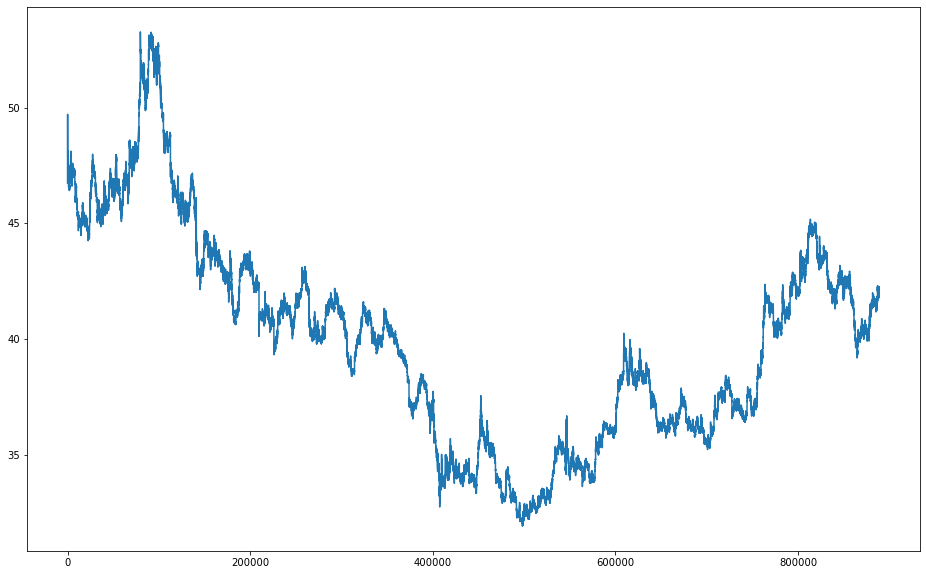

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the maximum price of 2048 ticks
- plot the minimum price of 2048 ticks

In [12]:
period_list = [4096]

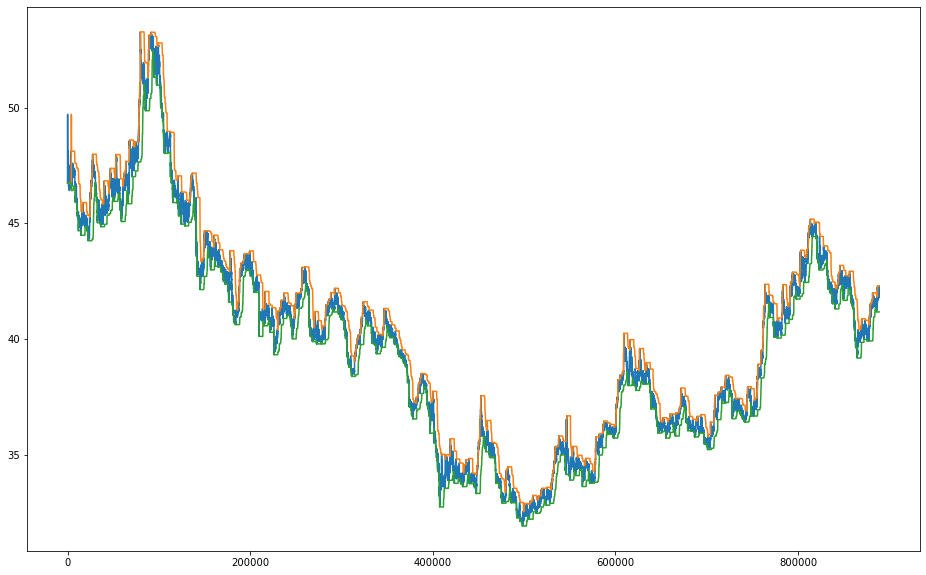

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.4096"].values)
plt.plot(data["min.4096"].values);

## we can see the result meets our expectation
## it may take long time to calculate the min and max of wpr prices
## I give you the estimated time of using 4 cores, so you can deal with other affairs while waiting for result
## but signals using min/max would be sometimes very useful
## the the time to calculating min/max pay off in the end
## In practice, when using c++ to calculating min/max on a rolling basis
## there would be some efficient algorithm, which is faster than comparing all numbers at every tick
## we would talk about it later in our C++ class

- Test 5 predictive signals and generate each result
- now let's see the first signal, which is simply related to price action without trading volume


- set the sample period length

In [14]:
period = 4096

- the first signal

In [27]:
## utilize the bid and ask quantity changes
## but the original quantity may not be stationary, i.e. it would have very large values
## usually from 0 to 200
## but can be up to several tens of thousand
## so we use the change of qty's direction instead
## it has only -1 0 1 so it's stionary, but it's dicrerte
## then we add ewma as fitler to make it more continuous
## we hope the signals are continuous values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        bid_qty = data["bid1.qty"]+data["bid2.qty"]+data["bid3.qty"]+data["bid4.qty"]+data["bid5.qty"]
        diff_bid_qty = bid_qty - bid_qty.shift()
        diff_bid_qty[0] = 0
        ask_qty = data["ask1.qty"]+data["ask2.qty"]+data["ask3.qty"]+data["ask4.qty"]+data["ask5.qty"]
        diff_ask_qty = ask_qty - ask_qty.shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [28]:
x3 = foctor_dbook_period()
x3


factor_name:
dbook.period

formula:
    def formula(self, data, period):
        bid_qty = data["bid1.qty"]+data["bid2.qty"]+data["bid3.qty"]+data["bid4.qty"]+data["bid5.qty"]
        diff_bid_qty = bid_qty - bid_qty.shift()
        diff_bid_qty[0] = 0
        ask_qty = data["ask1.qty"]+data["ask2.qty"]+data["ask3.qty"]+data["ask4.qty"]+data["ask5.qty"]
        diff_ask_qty = ask_qty - ask_qty.shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[4096]

- create directory for dbook signal

In [29]:
SAVE_PATH = "e:/intern"
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH)

e:/intern/tmp pkl/601318/dbook.4096
e:/intern/tmp pkl/601628/dbook.4096
e:/intern/tmp pkl/601601/dbook.4096
e:/intern/tmp pkl/601336/dbook.4096
e:/intern/tmp pkl/000627/dbook.4096


In [18]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH,n=8)
;

# Wall time: 1min 56s

Wall time: 1min 56s


''

In [13]:
def moving_average(a, n=3) :
    ret_sum = np.cumsum(a, dtype=float)
    ret = a
    ret[n:] = (ret_sum[n:] - ret_sum[:-n])/n
    return ret

- now we write the all.signal part into a function

In [14]:
def get_all_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        signal = S
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

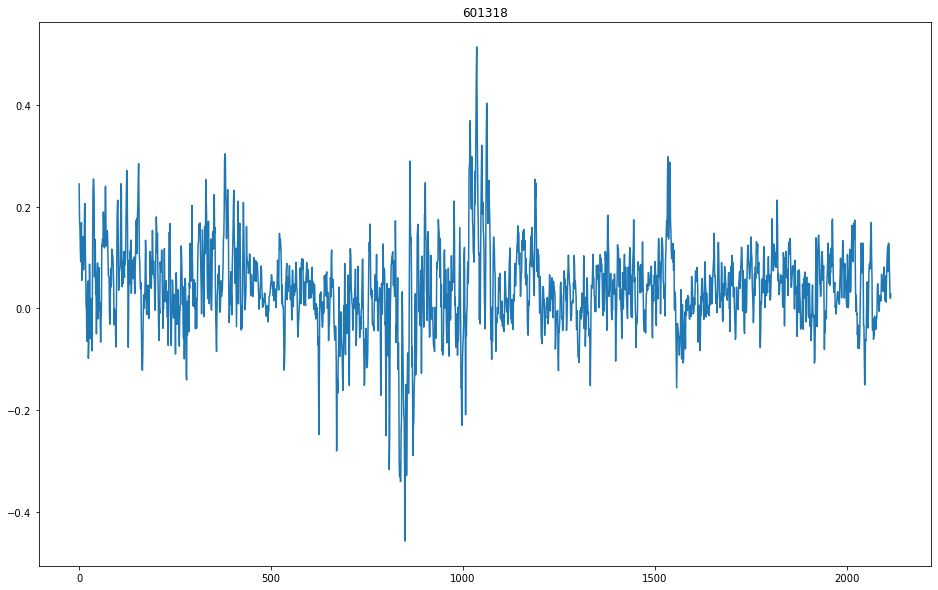

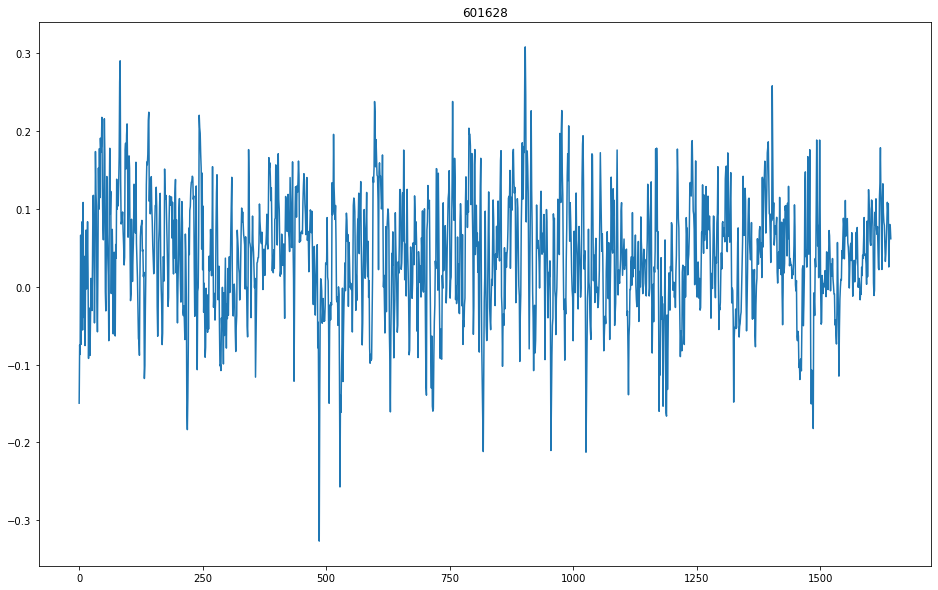

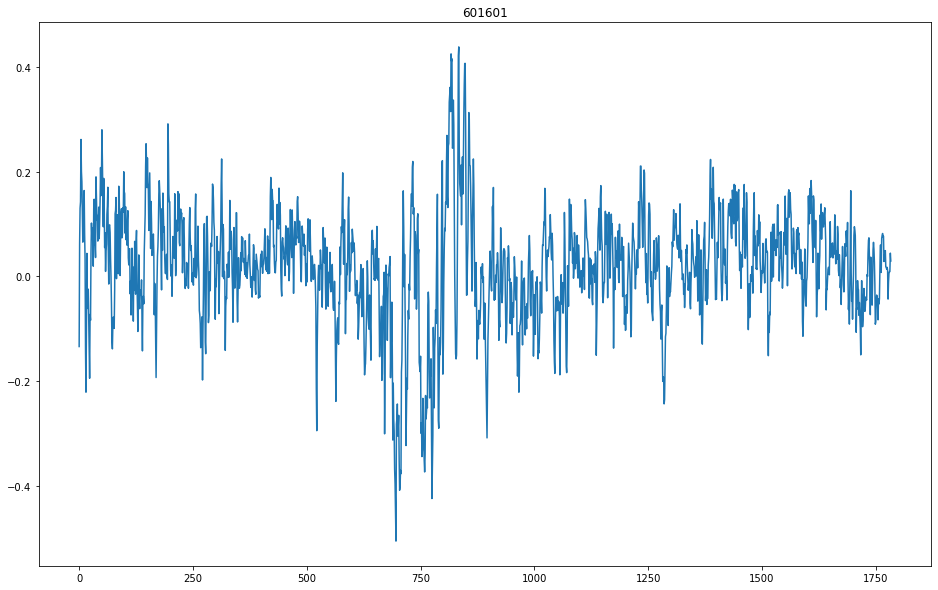

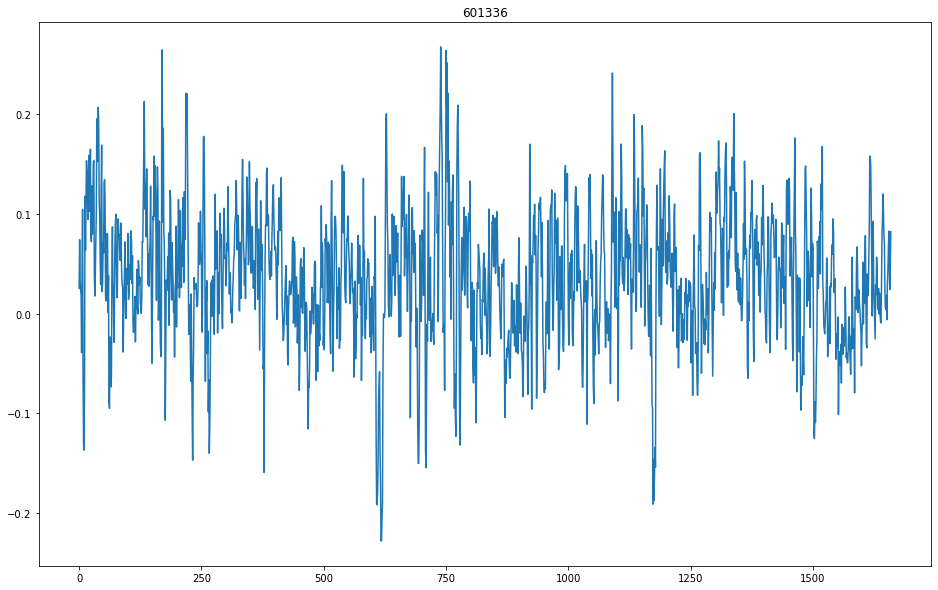

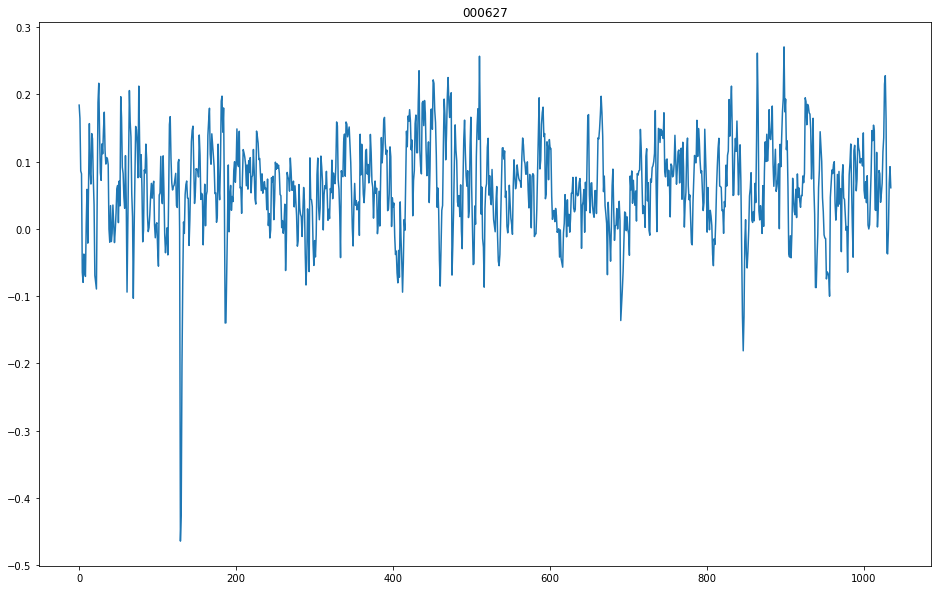

In [21]:
i = 0
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "dbook."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [22]:
print(len(all_signal))
## 1035


1035


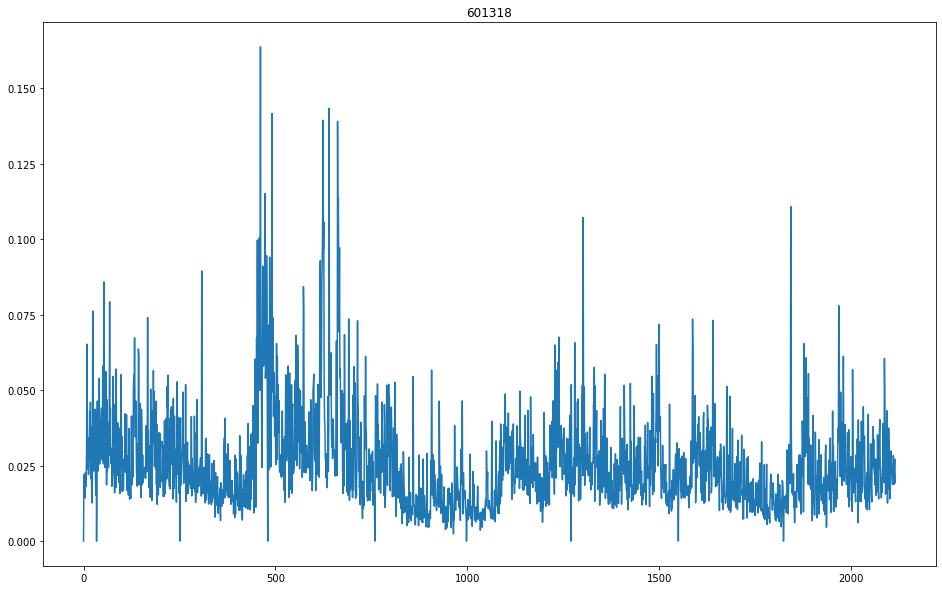

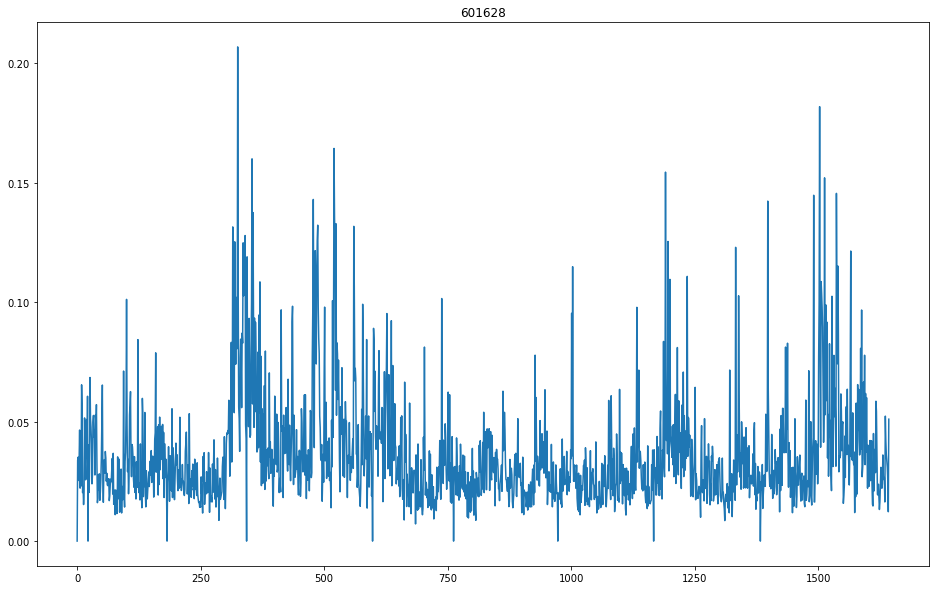

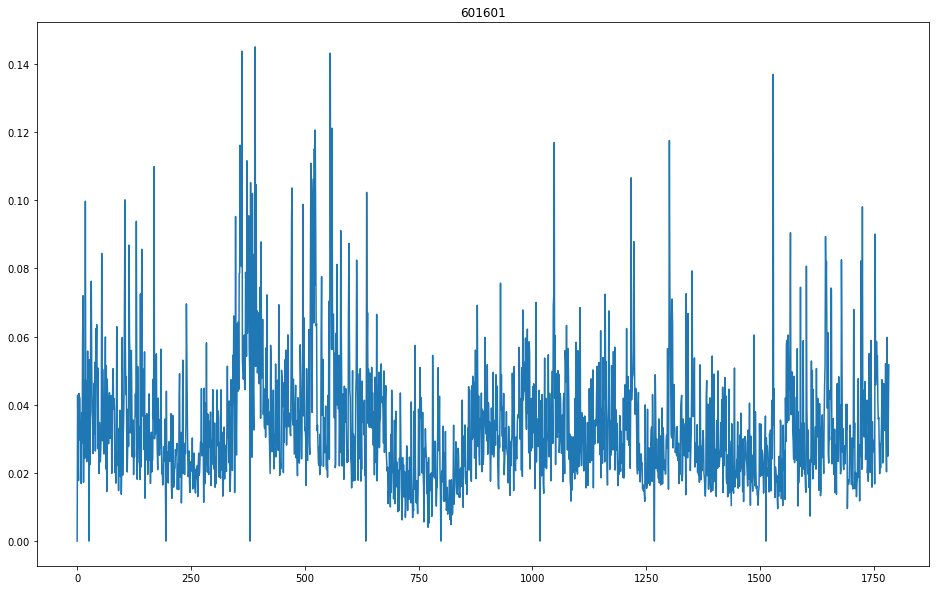

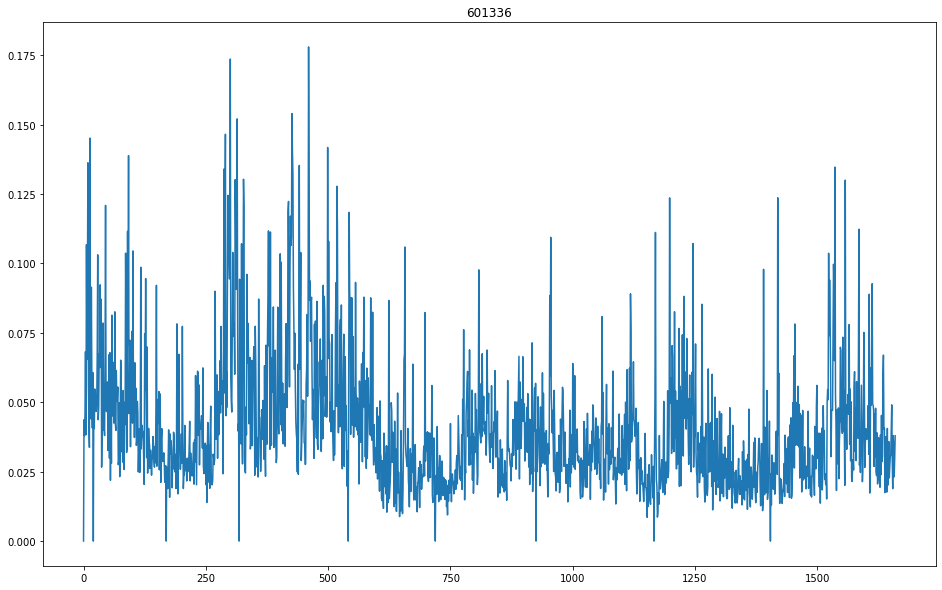

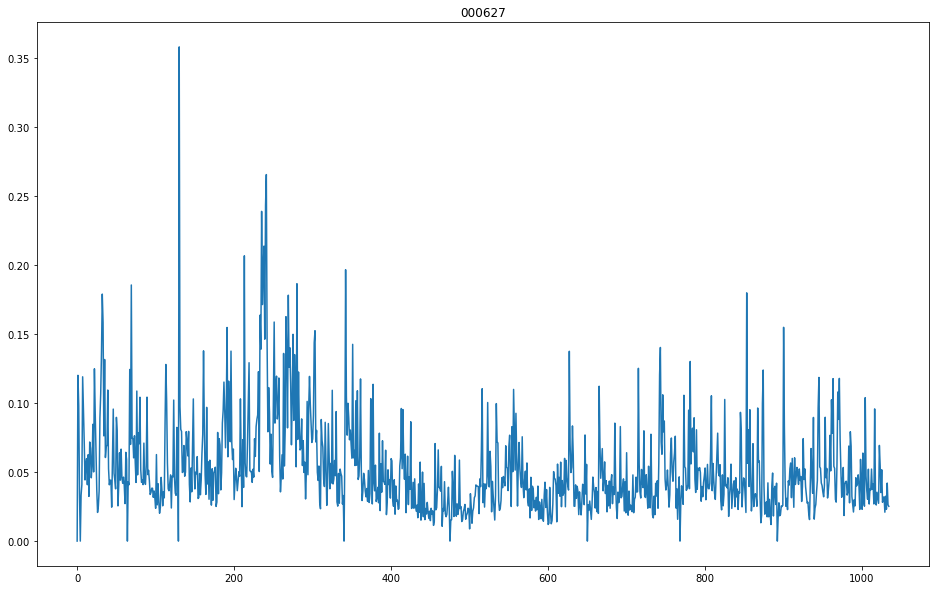

In [23]:
i = 0
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "atr."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

In [23]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

- get the result of training sample

In [15]:
from collections import OrderedDict
def get_hft_summary(result, thre_mat):
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((0,n_thre))
    all_dates = np.array([])
    for i in range(len(result)):
        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)
        all_dates = np.append(all_dates, result[i]["date"])
    stat = result[0]["result"].iloc[:,2:]
    for i in range(1,len(result)):
        stat = stat+result[i]["result"].iloc[:,2:]
    stat["avg.ret"]=stat["ret"]/stat["num"]
    
    total_ret = all_pnl.sum(0)
    total_sharpe = np.zeros(n_thre)
    total_drawdown = np.zeros(n_thre)
    total_max_drawdown = np.zeros(n_thre)
    for i in range(n_thre):
        total_sharpe[i] = sharpe(all_pnl[:,i])
        total_drawdown[i] = drawdown(all_pnl[:,i])
        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]),
                                                  ("avg.ret", stat["avg.ret"]), ("total.ret",total_ret), ("sharpe", total_sharpe),
                                                  ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown),
                                                 ("mar", total_ret/total_max_drawdown)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.pnl", all_pnl), ("date", all_dates)])

In [26]:
thre_mat

open  close
0   0.10 -0.020
1   0.10 -0.040
2   0.10 -0.060
3   0.10 -0.080
4   0.10 -0.100
..   ...    ...
95  0.29 -0.058
96  0.29 -0.116
97  0.29 -0.174
98  0.29 -0.232
99  0.29 -0.290

[100 rows x 2 columns]

In [16]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,
                   HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    cur_spread = data["ask1"]-data["bid1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]/data["adjust"][notional_position_pos==1]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][notional_position_neg==-1]/data["adjust"][notional_position_neg==-1]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        #change_pos = position - position.shift(1)
        #notional_change_pos = notional_position-notional_position.shift(1)
        change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        #notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"][change_buy]
        change_base[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"][change_sell]
        raw_pnl = -(change_base*change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(change_pos))
        num = sum((position!=0) & (change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

In [20]:
period = 4096

In [21]:
signal_name = "dbook."+str(period)

In [28]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
SAVE_PATH = "e:/intern"
for product in product_list:
    all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product)))
    n_days = len(all_dates)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    all_trade_stat[product] = trade_stat

## Wall time: 38min 55s

Wall time: 38min 55s


In [29]:
## save backtest result
save(all_trade_stat, SAVE_PATH+"/"+"insurance_trade_stat_"+signal_name+".pkl")

In [30]:
all_trade_stat = load(SAVE_PATH+"/"+"insurance_trade_stat_"+signal_name+".pkl")

- get the statistics result of training sample

- let's see how many good signals there are

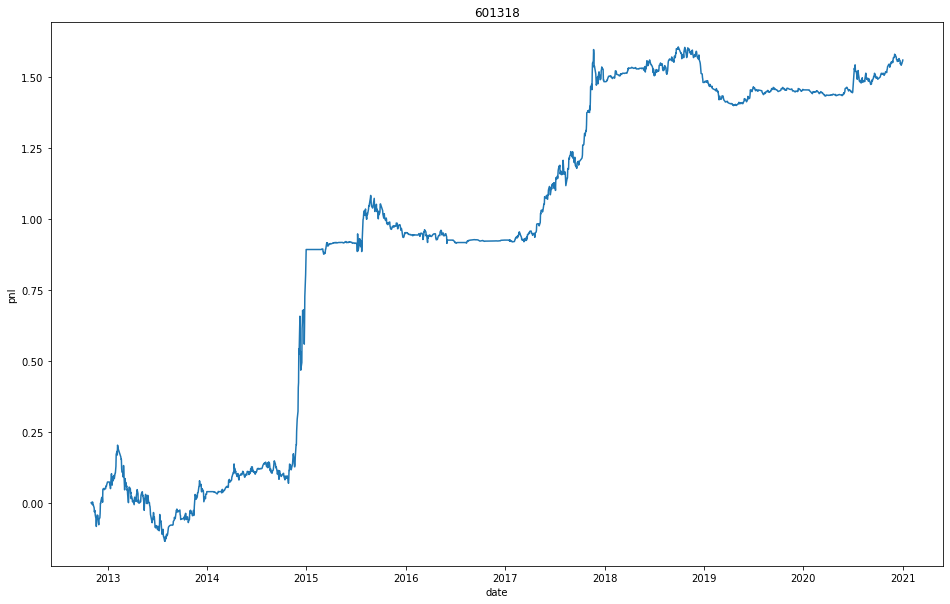

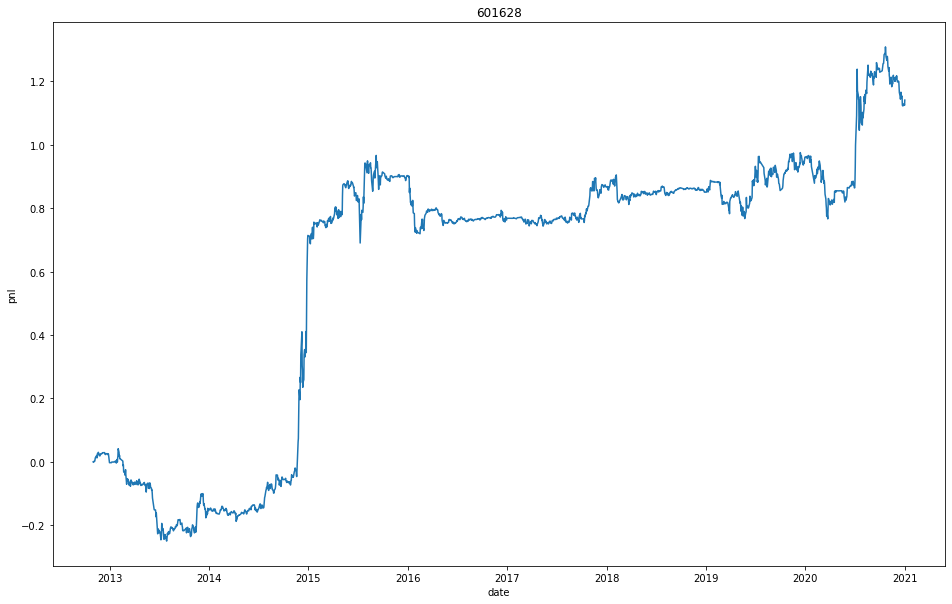

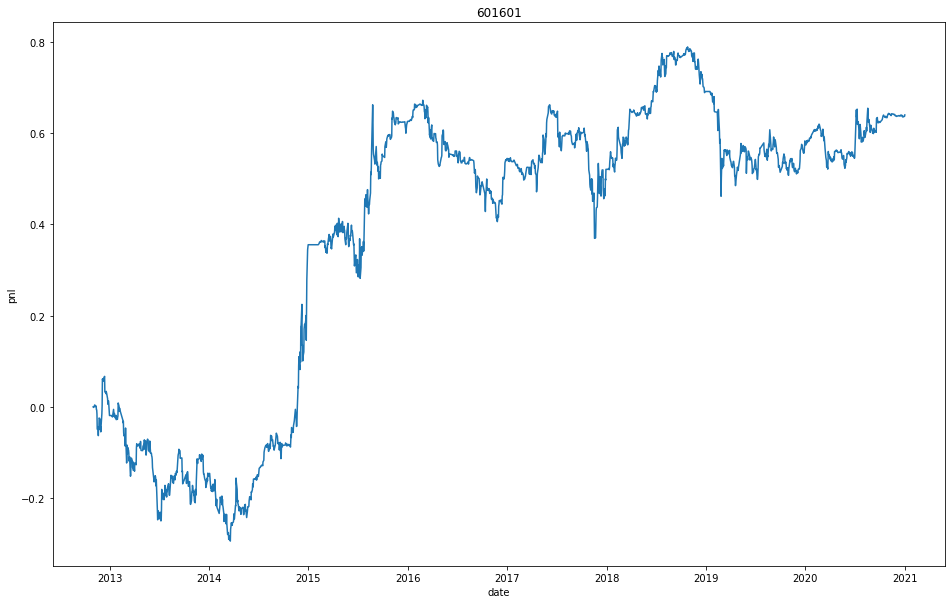

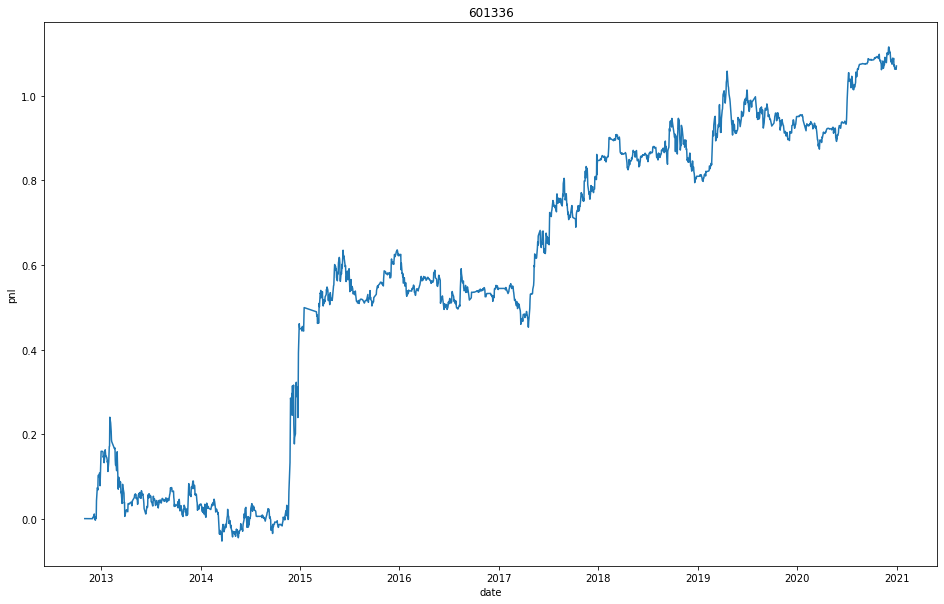

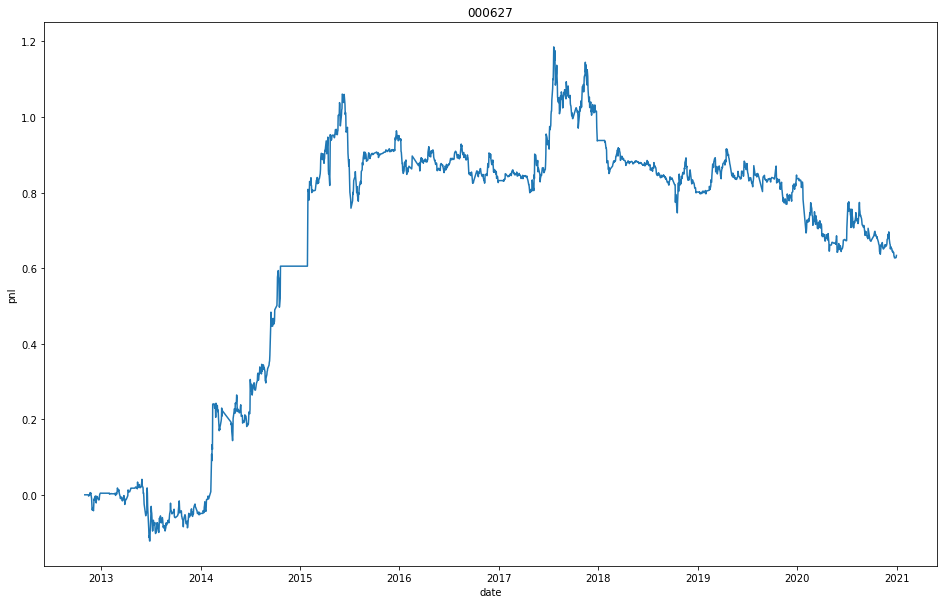

In [31]:
i = 0
for product in product_list:
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.ret"]>0.001
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

- we can see the result is quite good
- now we can split the samples into training and testing sets

In [36]:
%%time
train_trade_stat = dict([])
for product in product_list:
    all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
    all_dates = all_dates[all_dates<"2017"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, 
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    train_trade_stat[product] = trade_stat
    
## Wall time: 27min 47s

Wall time: 27min 47s


In [37]:
save(train_trade_stat, SAVE_PATH+"/insurance_" + signal_name+"_train_trade_stat.pkl")

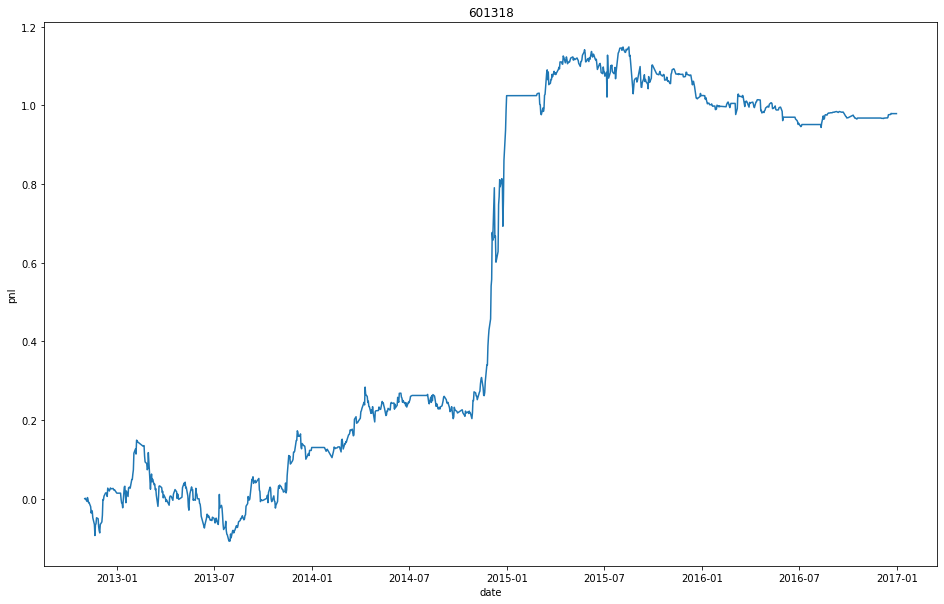

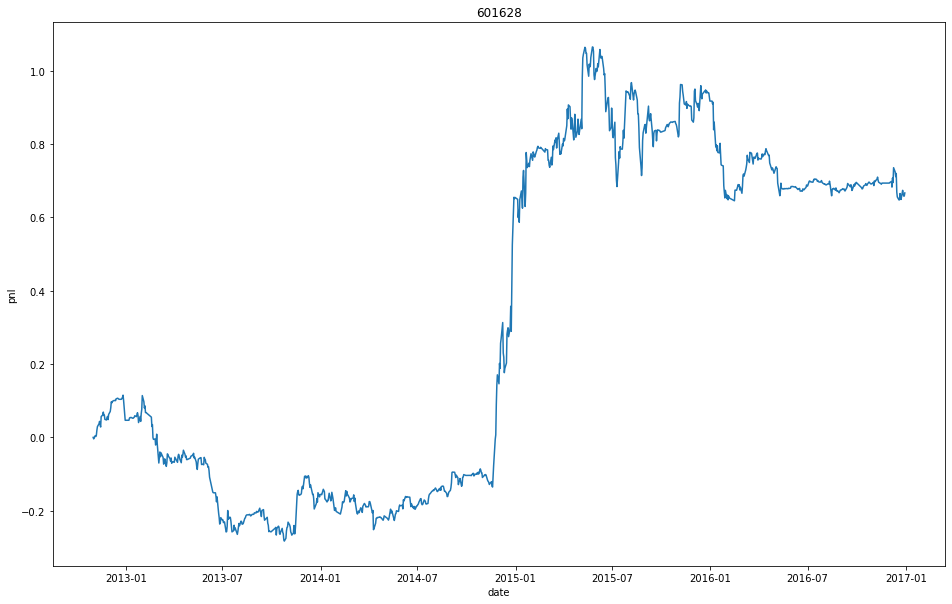

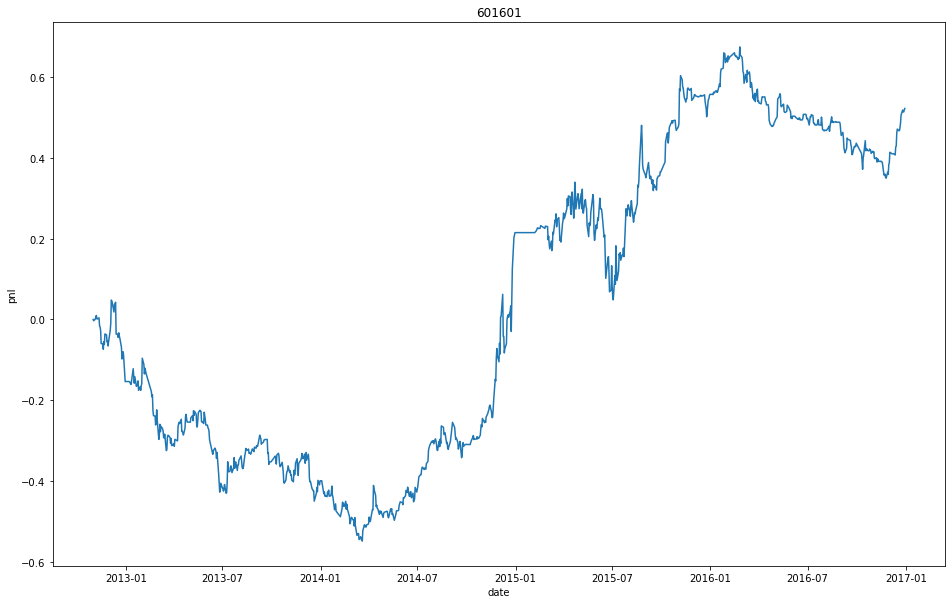

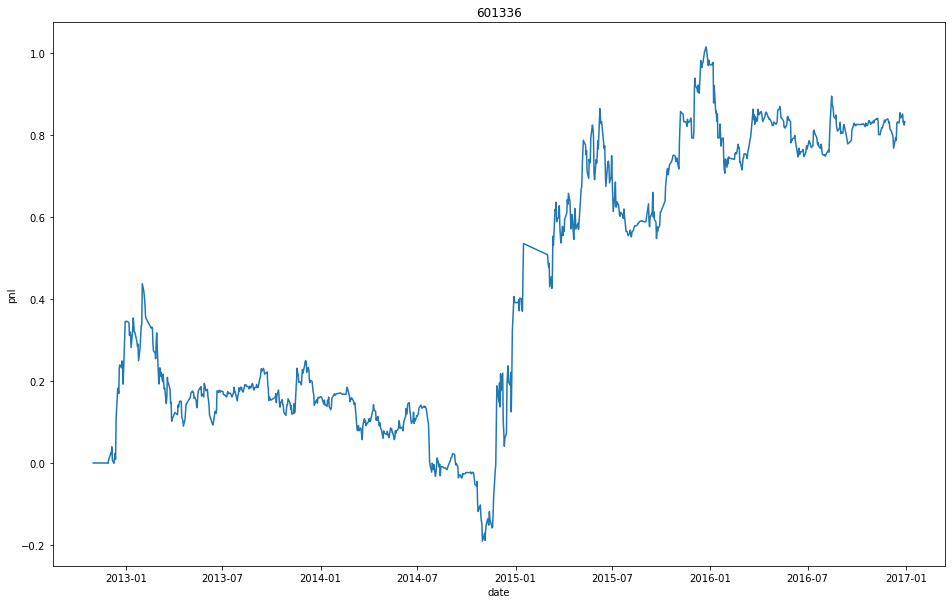

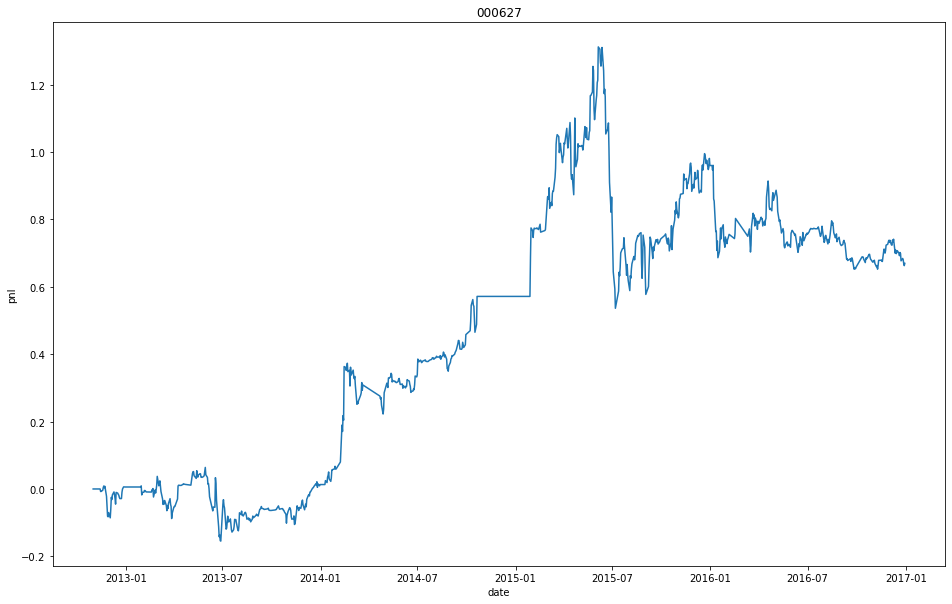

In [38]:
i = 0
train_trade_stat = load(SAVE_PATH+"/insurance_" + signal_name +"_train_trade_stat.pkl")
for product in product_list:
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001)  & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

In [30]:
%%time
test_trade_stat = dict([])
for product in product_list:
    all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
    all_dates = all_dates[all_dates>="2017"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    test_trade_stat[product] = trade_stat
    
## Wall time: 32min 30s

Wall time: 32min 30s


In [31]:
save(test_trade_stat, SAVE_PATH+"/insurance_" + signal_name+"_test_trade_stat.pkl")

In [32]:
product_list

['601318', '601628', '601601', '601336', '000627']

601318 train sharpe  0.9636988687977178 test sharpe  1.2226194658508807
601628 train sharpe  0.871688051112964 test sharpe  0.43887212641474455
601601 train sharpe  0.6365616649527067 test sharpe  0.053868221640247176
601336 train sharpe  0.8458849725985196 test sharpe  0.8148732051134198
000627 train sharpe  0.8972697557485587 test sharpe  -0.28361031245487556


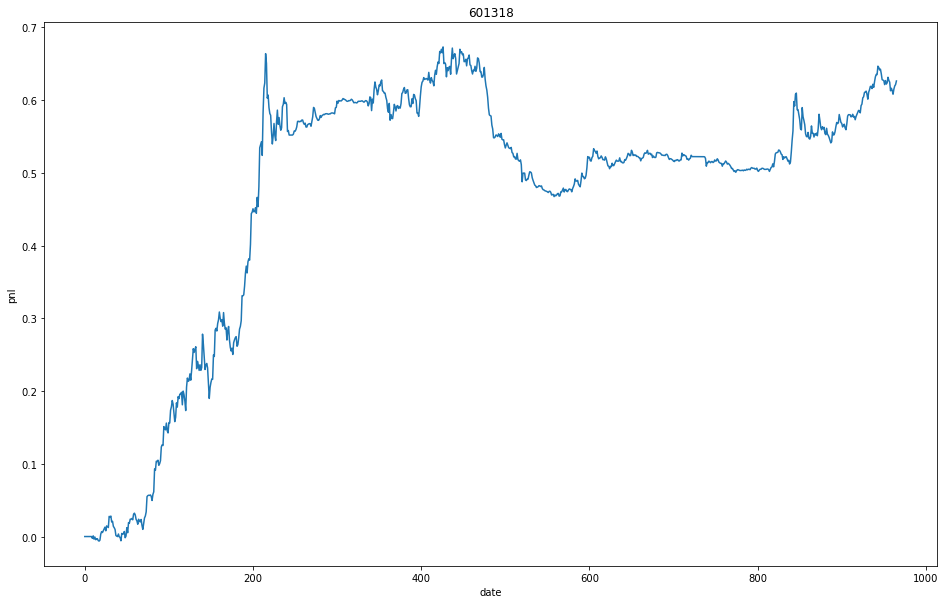

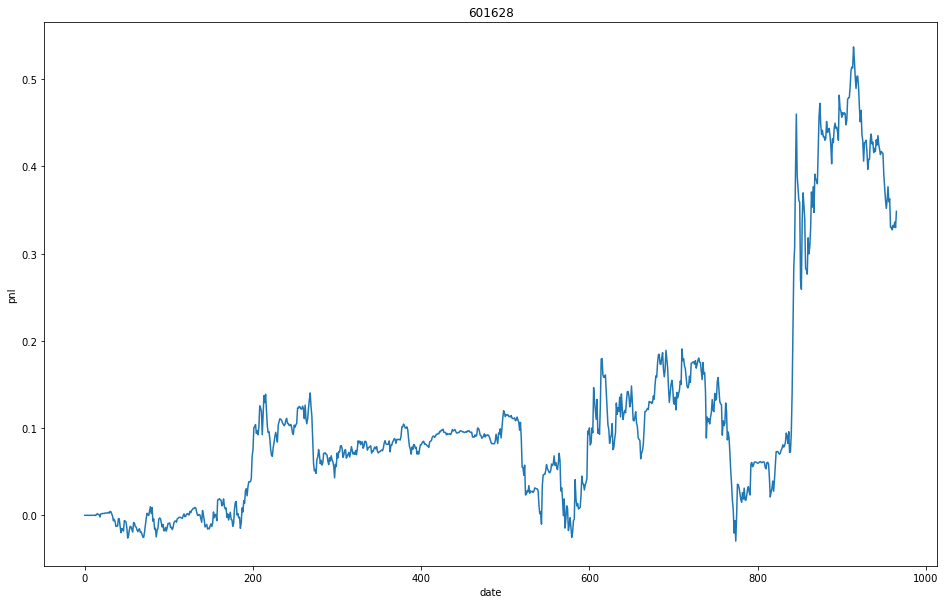

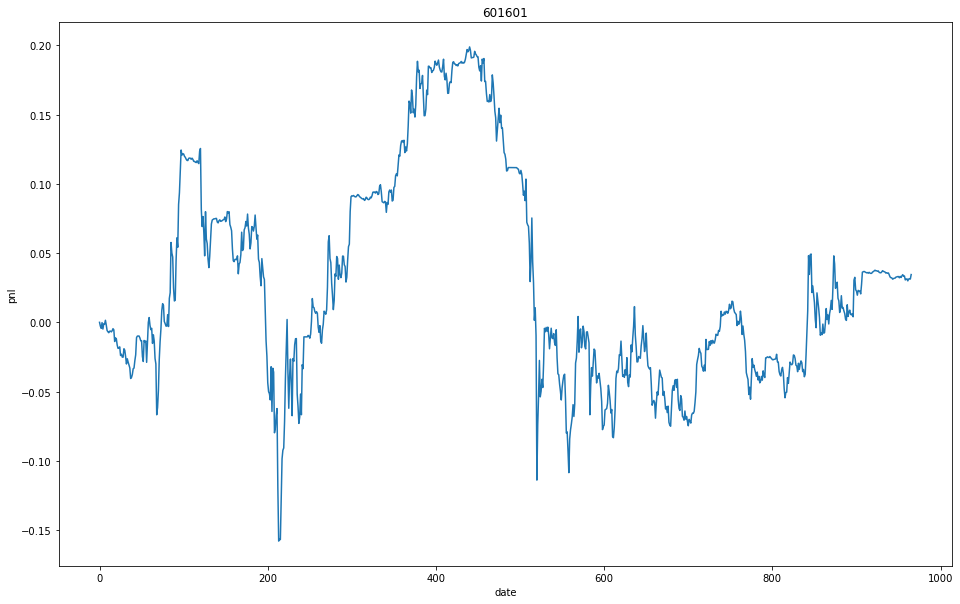

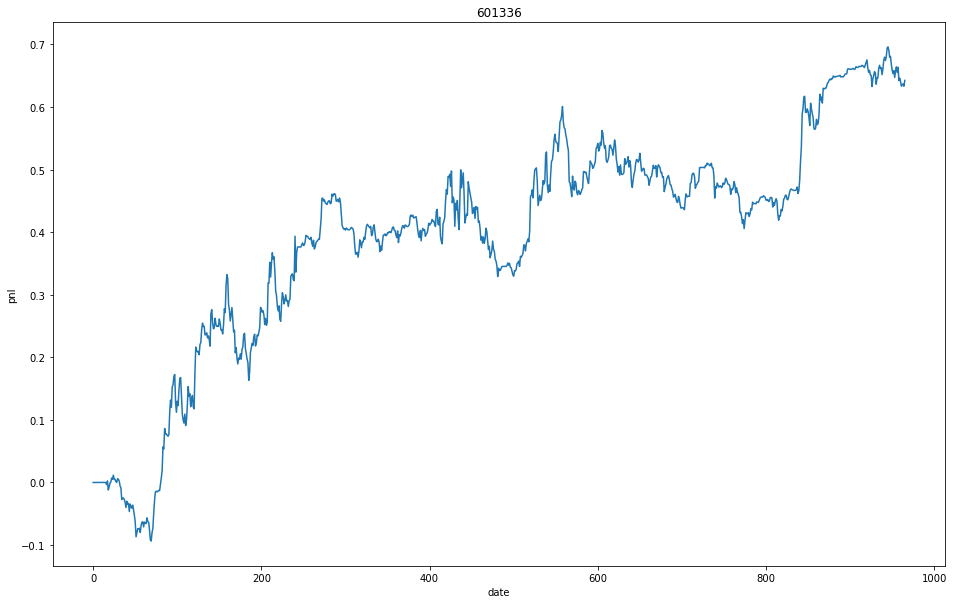

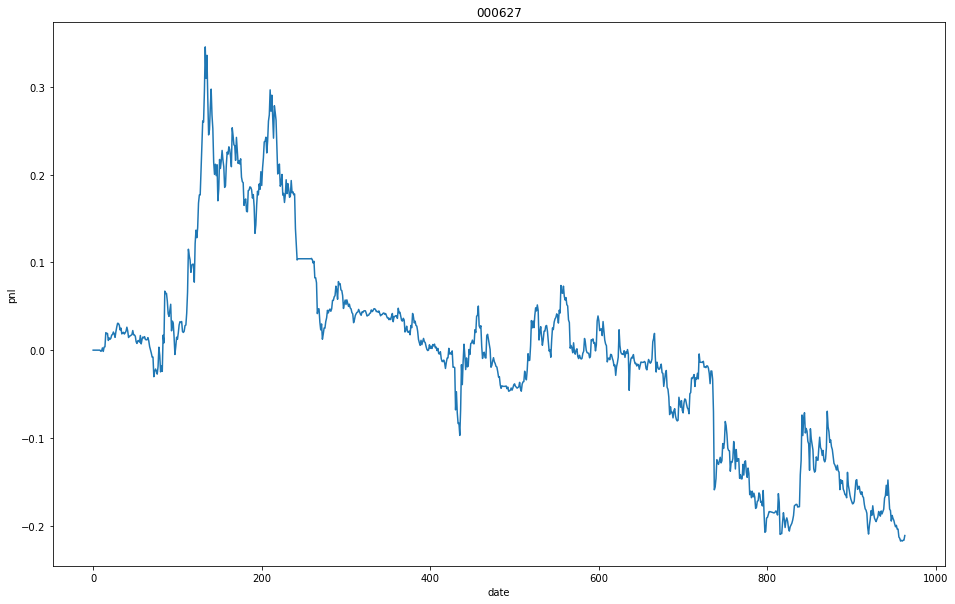

In [33]:
test_trade_stat = load(SAVE_PATH+"/insurance_" + signal_name +"_test_trade_stat.pkl")
train_trade_stat = load(SAVE_PATH+"/insurance_" + signal_name +"_train_trade_stat.pkl")
i = 0
for product in product_list:
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(test_pnl.cumsum());
    
# 601318 train sharpe  0.9636988687977178 test sharpe  1.2226194658508807
# 601628 train sharpe  0.871688051112964 test sharpe  0.43887212641474455
# 601601 train sharpe  0.6365616649527067 test sharpe  0.053868221640247176
# 601336 train sharpe  0.8458849725985196 test sharpe  0.8148732051134198
# 000627 train sharpe  0.8972697557485587 test sharpe  -0.28361031245487556



- at last we plot the selected pnl

- we can check its sharp ratio

- now let's check how it performs on the test set

- now we see the pnl curve

possible solution:
- choose strategies not based on performance, we can limit the parameters to a small range, and use risk parity to allocate weights to all of them;
- we can use Bayesian Optimization to choose parameters automatically to avoid humen intervention;
- maybe adding i can make the strategies break new high recently

we can try these solutions in the future

- at last we plot the selected pnl

- now we can combine all of these to a function

In [34]:
reverse_list = dict([])
for product in product_list:
    reverse_list[product] = 1


In [35]:
atr_filter_list = dict([])
for product in product_list:
    atr_filter_list[product] =  0.02


In [36]:
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat


In [37]:
## get backtest result of a signal on a product's list
from collections import OrderedDict
def get_list_signal_stat(signal_name, thre_mat_list, product_list, atr_filter_list,
                    split_str="2018", min_pnl=2, min_num=20, reverse=1):
    CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
    train_trade_stat = dict([]) ## training result statistics
    print("training")
    for product in product_list:
        print(product)
        all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
        train_sample = np.array(all_dates)<split_str ## training samples
        test_sample = np.array(all_dates)>split_str ## test samples
        print(sum(train_sample), sum(test_sample))
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat)
        train_trade_stat[product] = trade_stat
    print("testing")
    test_trade_stat = dict([])
    for product in product_list:
        all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
        print(product)
        train_sample = np.array(all_dates)<split_str ## training samples
        test_sample = np.array(all_dates)>split_str ## test samples
        thre_mat = thre_mat_list[product]
        reverse = reverse_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
            result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(result, thre_mat)
        test_trade_stat[product] = trade_stat
    result=dict([])
    result["train_trade_stat"] = train_trade_stat ## save train stat
    result["test_trade_stat"] = test_trade_stat ## save test stat
    if reverse==-1:
        save(result, HEAD_PATH+"/"+signal_name+".result.pkl") ## reversal strategy
    else:
        save(result, HEAD_PATH+"/"+signal_name+".pos.result.pkl") ## trend strategy

In [38]:
## get train and test result, choose good strategies, plot the portfolio and result of each product

def get_list_signal_result(signal_name, product_list, split_str="2018", reverse=1,
                           min_pnl=2, min_num=20, atr_filter=20):
    if reverse==-1:
        result = load(HEAD_PATH+"/"+signal_name+".result.pkl") ## load reversal strat statistics
    else:
        result = load(HEAD_PATH+"/"+signal_name+".pos.result.pkl") ## load trend strat statistics
    train_trade_stat = result["train_trade_stat"]
    test_trade_stat = result["test_trade_stat"]
    i = 0
    train_dates = np.array([])
    for product in product_list:
        trade_stat = train_trade_stat[product]
        train_dates = np.unique(np.append(train_dates, trade_stat["date"]))
    train_dates.sort()   
    test_dates = np.array([])
    for product in product_list:
        trade_stat = test_trade_stat[product]
        test_dates = np.unique(np.append(test_dates, trade_stat["date"]))
    test_dates.sort()    
    for product in product_list:
        trade_stat = train_trade_stat[product]
        ## two criterion: minimum averge pnl (unit is spread), monimum number of trades
        good_strat = (trade_stat["final.result"]["avg.ret"]>min_pnl) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>0:
            train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
            i = i+1
    i = 0
    train_all_pnl = np.zeros([len(train_dates),len(product_list)])
    test_all_pnl = np.zeros([len(test_dates),len(product_list)])
    for product in product_list:
        trade_stat = train_trade_stat[product]
        good_strat = (trade_stat["final.result"]["avg.ret"]>min_pnl) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>1:
            train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
            train_index = np.searchsorted(train_dates,trade_stat["date"])
            train_all_pnl[train_index,i] = train_pnl
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
            test_index = np.searchsorted(test_dates,trade_stat["date"])
            test_all_pnl[test_index,i] = test_pnl
            print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
            i = i+1
    all_dates = np.append(train_dates,test_dates)
    test_sample = all_dates>=test_dates[0]
    format_dates = np.array([pd.to_datetime(d) for d in all_dates])
    train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
    test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
    all_portfolio = np.append(train_portfolio, test_portfolio)
    plt.figure(1, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title("portfolio");
    plt.plot(format_dates, all_portfolio.cumsum());
    plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
    print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

In [39]:
%%time
get_list_signal_stat("dbook.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)

# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 47s






training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 47s


601318 train sharpe  0.9423690615831215 test sharpe  0.8911776684145744
601628 train sharpe  0.5051335874677726 test sharpe  -0.06481379086442919
601601 train sharpe  0.42756820318760624 test sharpe  0.335420817195308
601336 train sharpe  0.5719117281316508 test sharpe  0.773185567751139
000627 train sharpe  0.4518308760060487 test sharpe  -0.31401493824880533
train sharpe:  0.7834341982976569 test sharpe:  0.40140544486349694


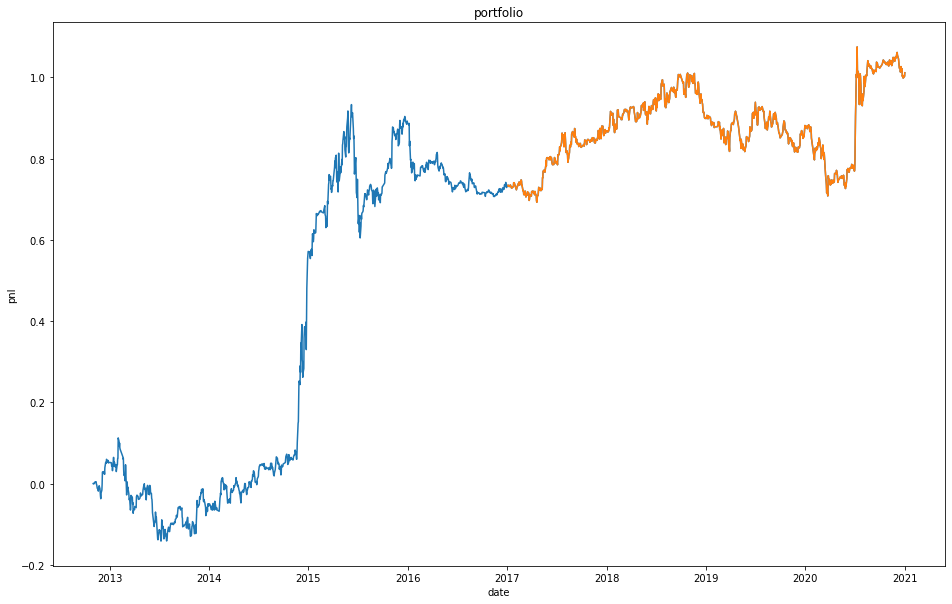

In [40]:
get_list_signal_result("dbook.4096", product_list, split_str="2017", reverse=1,min_pnl=0.001, min_num=20, atr_filter=0.02)

# 601318 train sharpe  0.9423690615831215 test sharpe  0.8911776684145744
# 601628 train sharpe  0.5051335874677726 test sharpe  -0.06481379086442919
# 601601 train sharpe  0.42756820318760624 test sharpe  0.335420817195308
# 601336 train sharpe  0.5719117281316508 test sharpe  0.773185567751139
# 000627 train sharpe  0.4518308760060487 test sharpe  -0.31401493824880533
# train sharpe:  0.7834341982976569 test sharpe:  0.40140544486349694






- we can test other signals

In [41]:
## any price is between minimum and maximum
## so if we use (price-min)/(max-min), the result is between [0,1]
## 0 is min, 1 is max
## then we subtract 0.5 from it
## then result is between -0.5 to 0.5
## and finally use ewma to take the average result over a range
from collections import OrderedDict
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

In [42]:
def get_range_pos(wpr, min_period, max_period, period):
    S = ewma(zero_divide(wpr-min_period, max_period-min_period), period, adjust=True) - 0.5
    S[:period] = 0
    return S


- let's see waht it looks like

In [43]:
x4_1 = foctor_range_pos_period()
## we've changed it a little bit from week 2 by adding
## xs.new <- gsub(para.name, value, xs)    
## aa <- with(data,eval(parse(text=xs.new)))
## so be aware that the name of parameter should be complex enough to avoid error

- now we can create path

In [44]:
for product in product_list:
    create_signal_path(x4_1, product, SAVE_PATH)

e:/intern/tmp pkl/601318/range.pos.4096
e:/intern/tmp pkl/601628/range.pos.4096
e:/intern/tmp pkl/601601/range.pos.4096
e:/intern/tmp pkl/601336/range.pos.4096
e:/intern/tmp pkl/000627/range.pos.4096


- then we calculate the signal

In [45]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4_1, product=product, HEAD_PATH=SAVE_PATH,n=8)
;

# Wall time: 1min 47s

Wall time: 1min 47s


''

- then we can see how the signal looks like

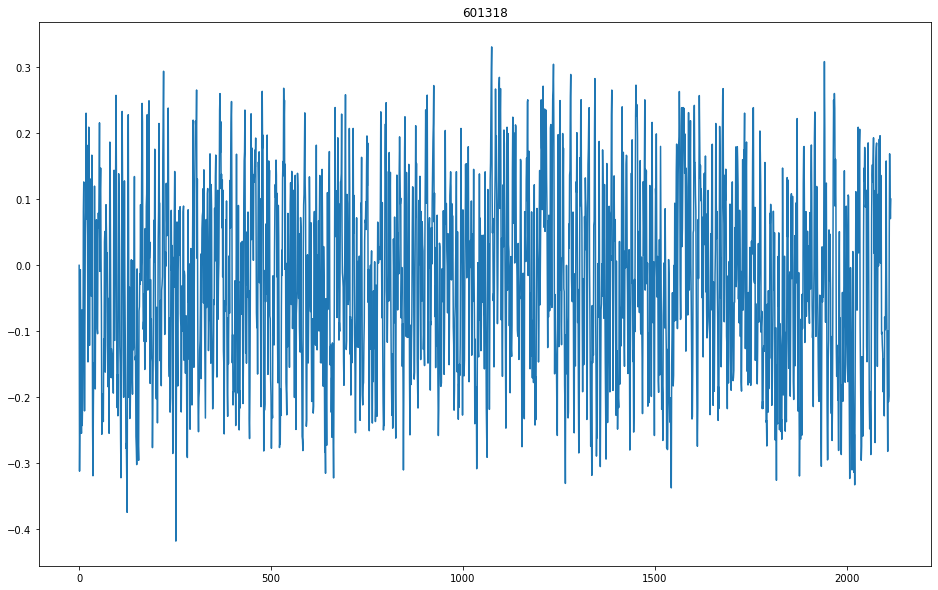

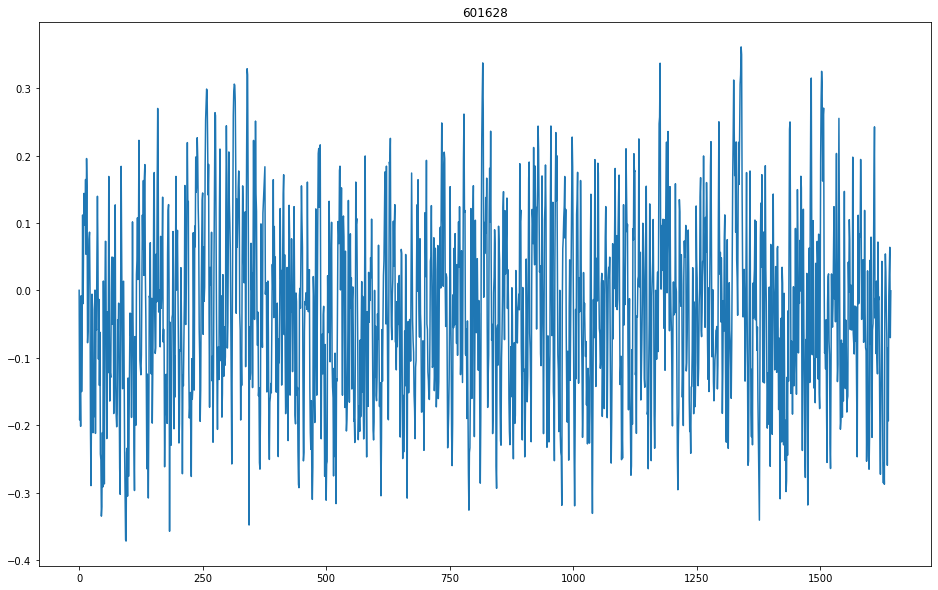

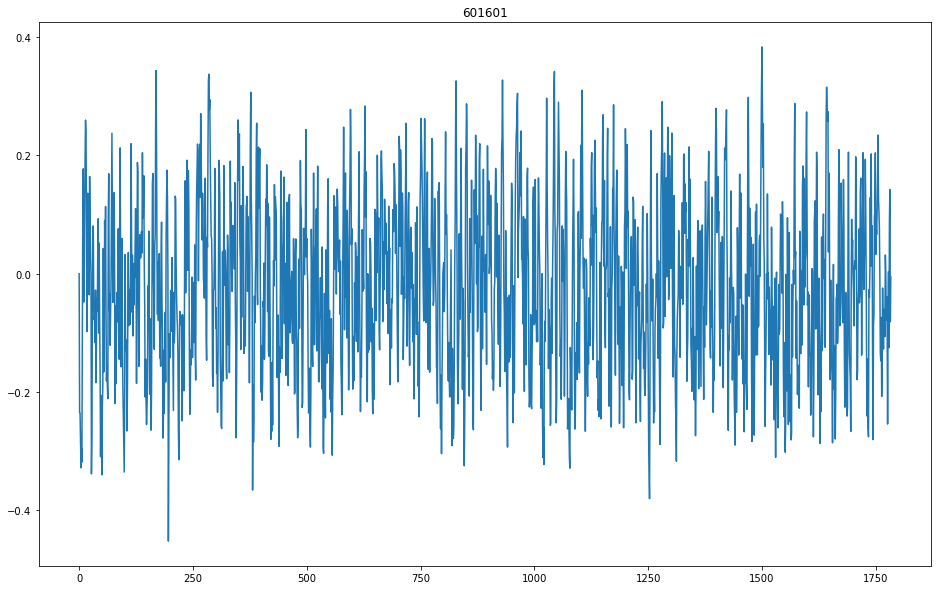

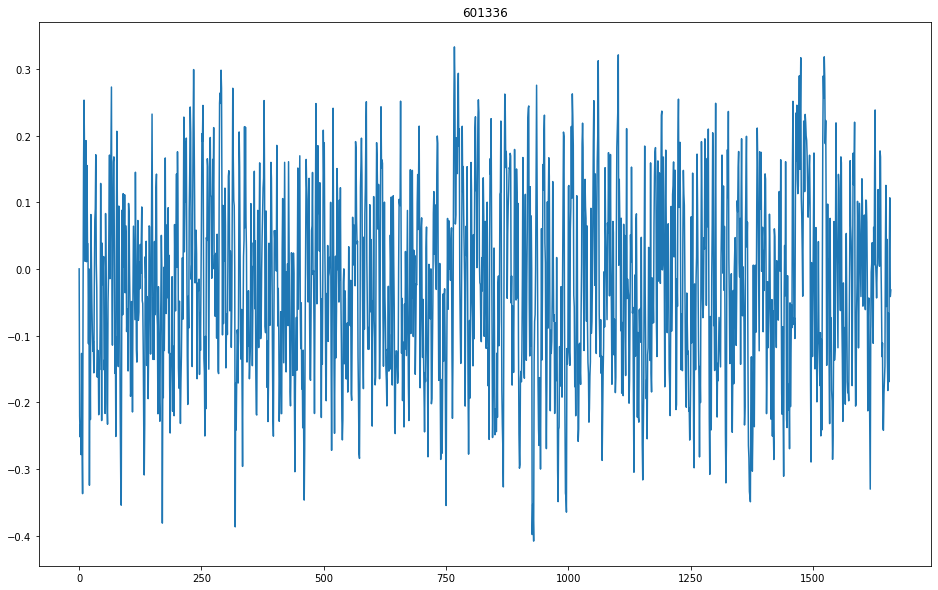

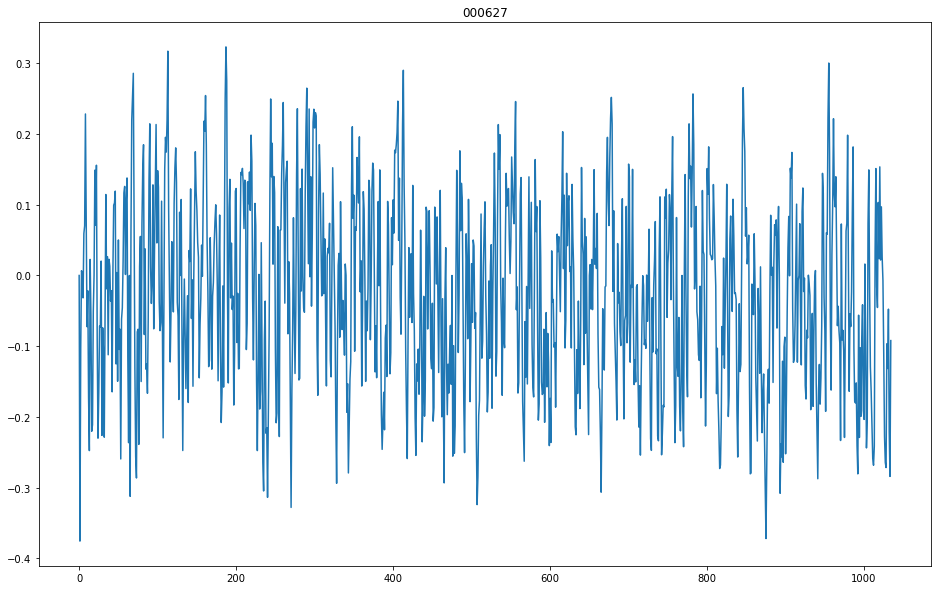

In [46]:
i = 0
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "range.pos."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

In [47]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [48]:
%%time
get_list_signal_stat("range.pos.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 1min 21s





training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 1min 21s


601318 train sharpe  0.298218923949115 test sharpe  -0.2658906169516981
601628 train sharpe  0.4892735440309014 test sharpe  -0.19132648130498467
601601 train sharpe  0.5396653338421091 test sharpe  -0.5196207860582976
601336 train sharpe  0.27356344613351186 test sharpe  0.10390573126641303
000627 train sharpe  0.2004523912677421 test sharpe  0.3157427316457334
train sharpe:  0.4838570361851566 test sharpe:  -0.15823337226685869


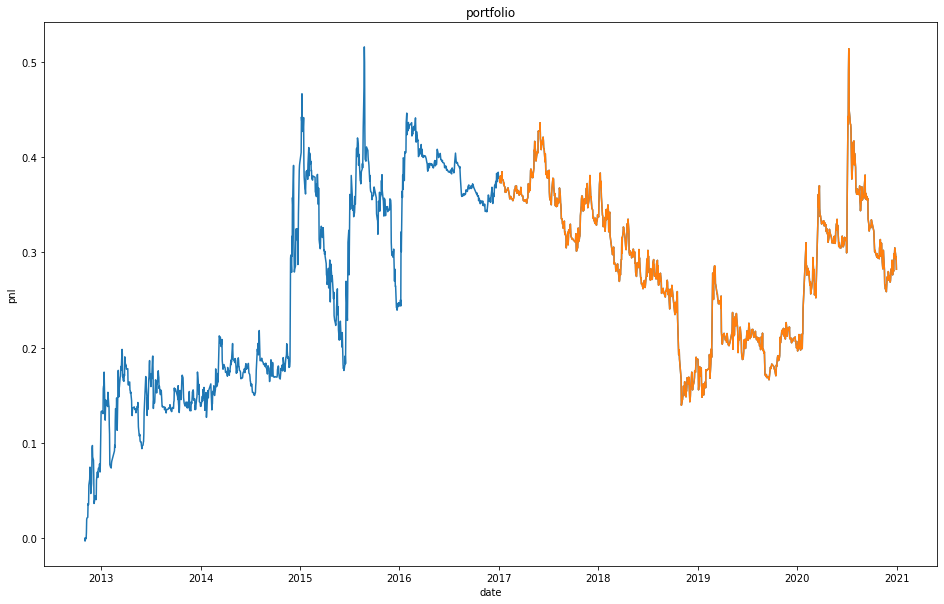

In [49]:
signal_stat = get_list_signal_result("range.pos.4096", product_list, reverse=1, min_pnl=0.001, min_num=10)

# 002594 train sharpe  0.1615616350344588 test sharpe  -0.5708646026491089
# 601633 train sharpe  0.4893705028884706 test sharpe  0.35166202928177737
# 000625 train sharpe  0.045950251836327 test sharpe  0.48344612116900065
# 601238 train sharpe  0.12482170788995398 test sharpe  -0.6409023325771477
# train sharpe:  0.31965155410305357 test sharpe:  0.05558219786036916






In [50]:
## double moving average
## long is perio,d short is round(period/10)
## we can use this idea to consturct many combinations
from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

In [51]:
x99_1 = foctor_ma_diff_period()

In [52]:
for product in product_list:
    create_signal_path(x99_1, product, SAVE_PATH)

e:/intern/tmp pkl/601318/ma.dif.10.4096
e:/intern/tmp pkl/601628/ma.dif.10.4096
e:/intern/tmp pkl/601601/ma.dif.10.4096
e:/intern/tmp pkl/601336/ma.dif.10.4096
e:/intern/tmp pkl/000627/ma.dif.10.4096


In [53]:
%%time
for product in product_list:
    print(product)
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x99_1, product=product, HEAD_PATH=SAVE_PATH, n=8)
;

# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 2min




601318
601628
601601
601336
000627
Wall time: 2min


''

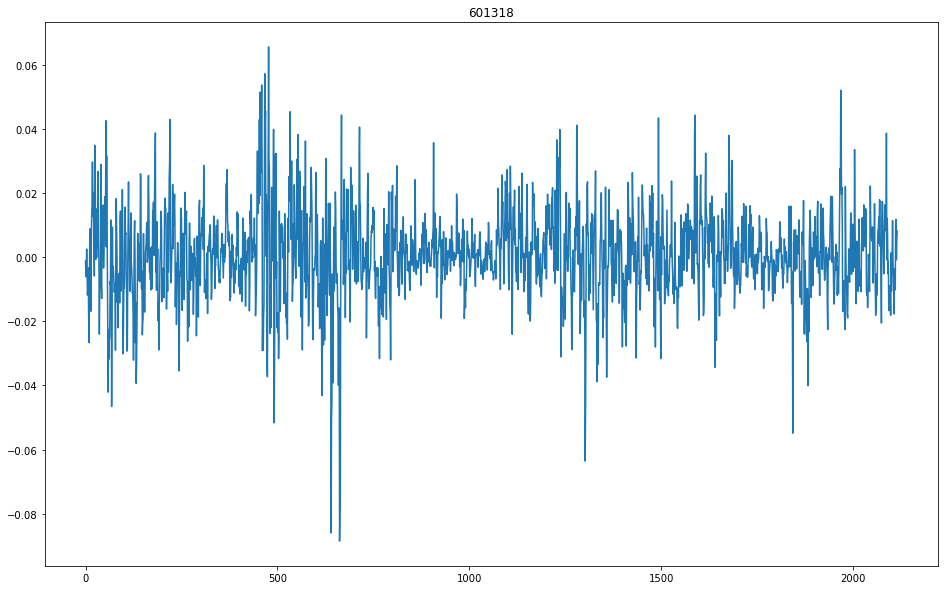

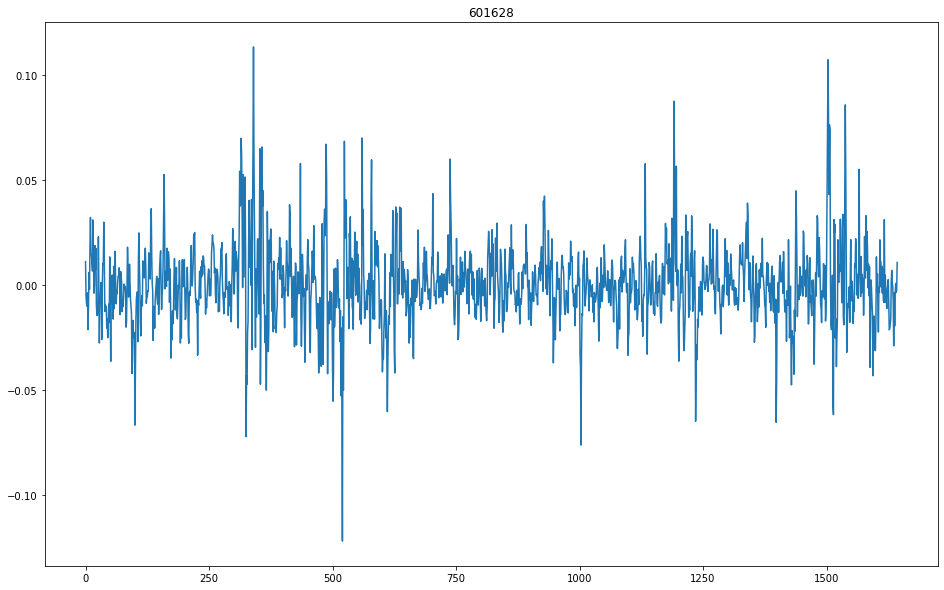

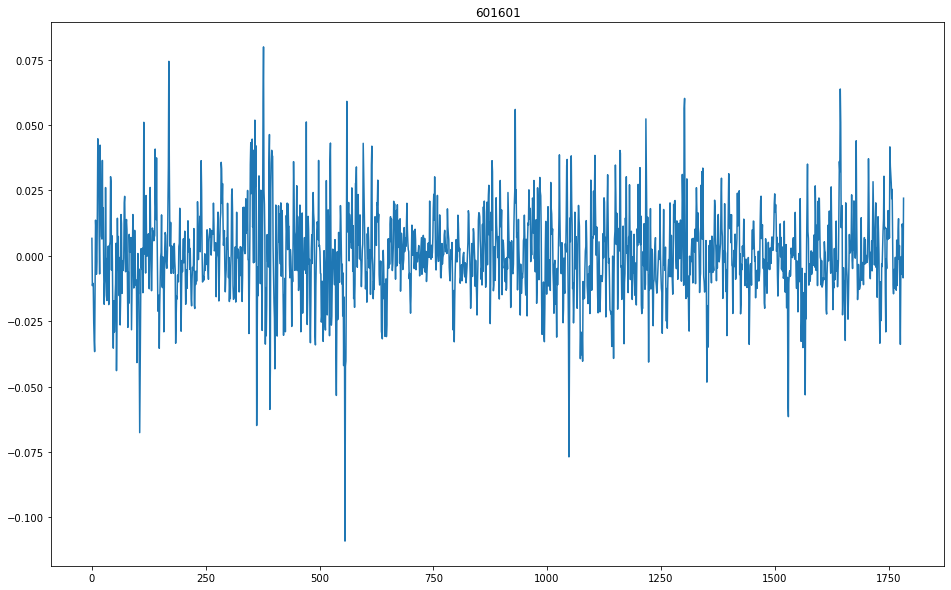

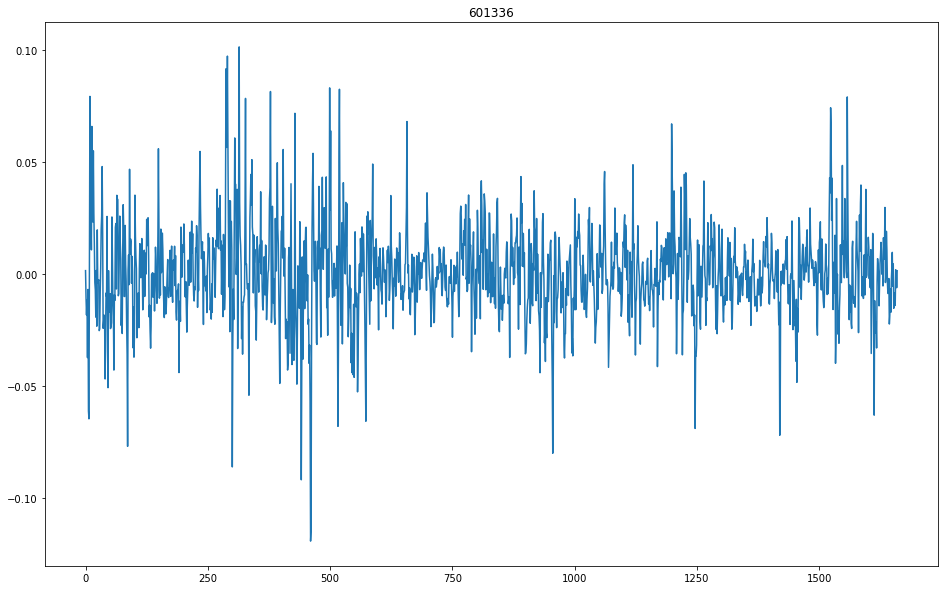

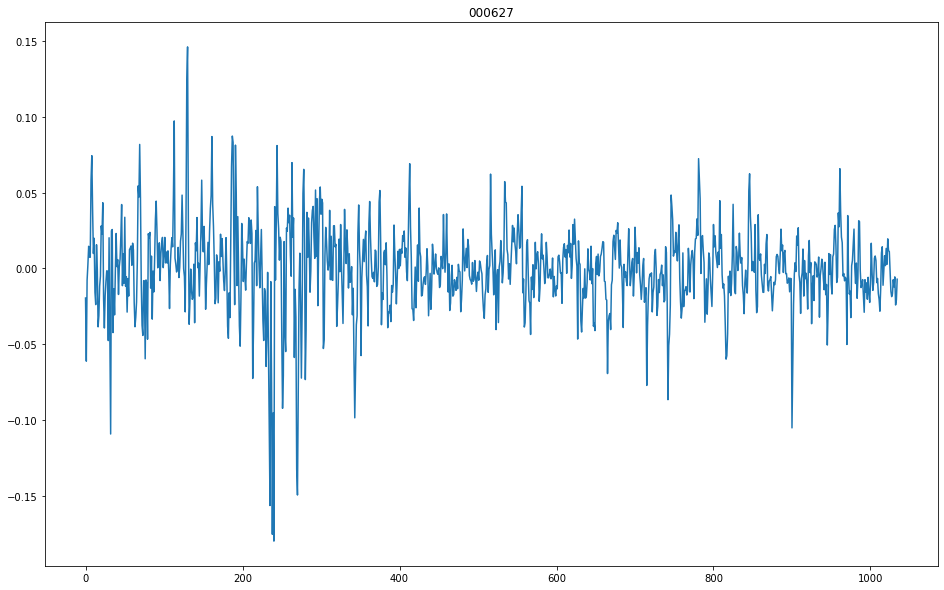

In [54]:
i = 0
period = 4096
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "ma.dif.10."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [55]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.07, 0.15, 0.004)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [56]:
%%time
get_list_signal_stat("ma.dif.10.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 1s



training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 1s


601318 train sharpe  0.4927619558358571 test sharpe  0.0948876937584825
601628 train sharpe  0.37941042033057853 test sharpe  0.08297809426438954
601601 train sharpe  0.13530975140483273 test sharpe  0.15108584547258563
601336 train sharpe  0.1348847321715201 test sharpe  0.20061254034316153
000627 train sharpe  0.11581302211116758 test sharpe  -0.07346360949739353
train sharpe:  0.30655518148741295 test sharpe:  0.12055433552682208


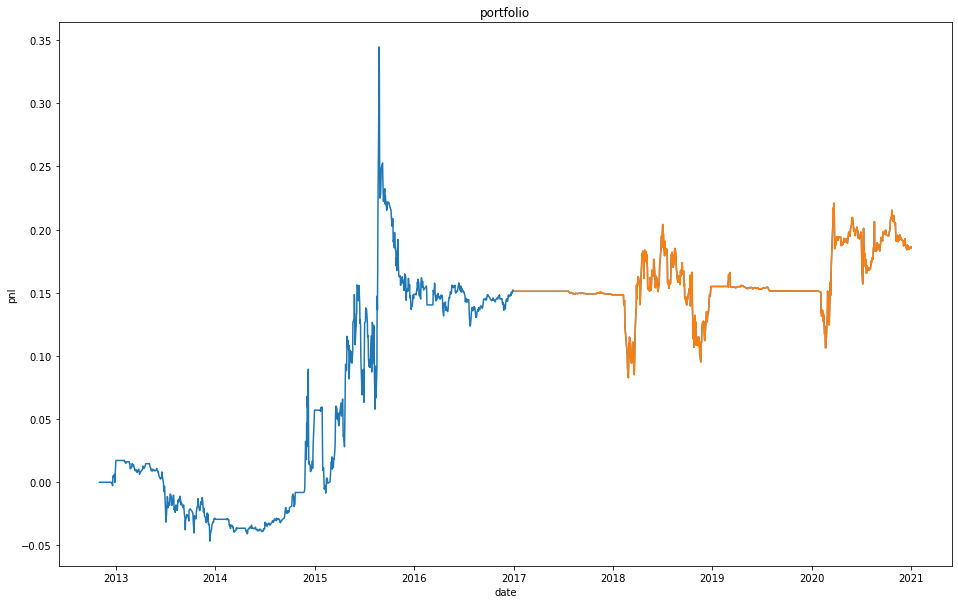

In [86]:
signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, reverse=1, min_pnl=0.001, min_num=0)

# 601318 train sharpe  0.4927619558358571 test sharpe  0.0948876937584825
# 601628 train sharpe  0.37941042033057853 test sharpe  0.08297809426438954
# 601601 train sharpe  0.13530975140483273 test sharpe  0.15108584547258563
# 601336 train sharpe  0.1348847321715201 test sharpe  0.20061254034316153
# 000627 train sharpe  0.11581302211116758 test sharpe  -0.07346360949739353
# train sharpe:  0.30655518148741295 test sharpe:  0.12055433552682208






In [58]:
## similar to double ewma
## but divided by price range
## and short period is round(period/20)
## for exampl.e period/2, period/4, period/8...
## now period = 4096 =2^12, 
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

In [59]:
x113 = foctor_price_osci_period()
for product in product_list:
    create_signal_path(x113, product, SAVE_PATH)

e:/intern/tmp pkl/601318/price.osci.4096
e:/intern/tmp pkl/601628/price.osci.4096
e:/intern/tmp pkl/601601/price.osci.4096
e:/intern/tmp pkl/601336/price.osci.4096
e:/intern/tmp pkl/000627/price.osci.4096


In [60]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x113, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
# Wall time: 1min 58s

Wall time: 1min 58s


''

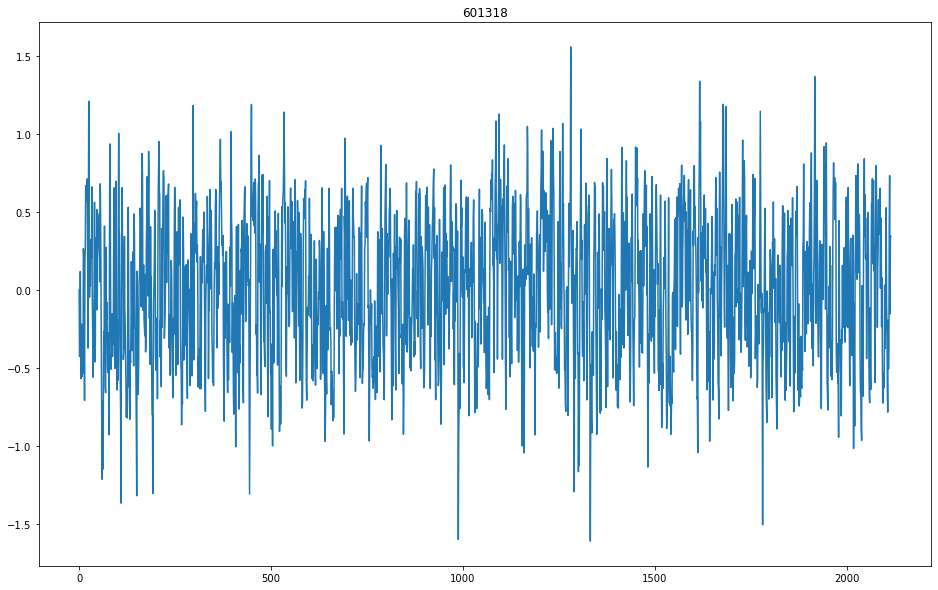

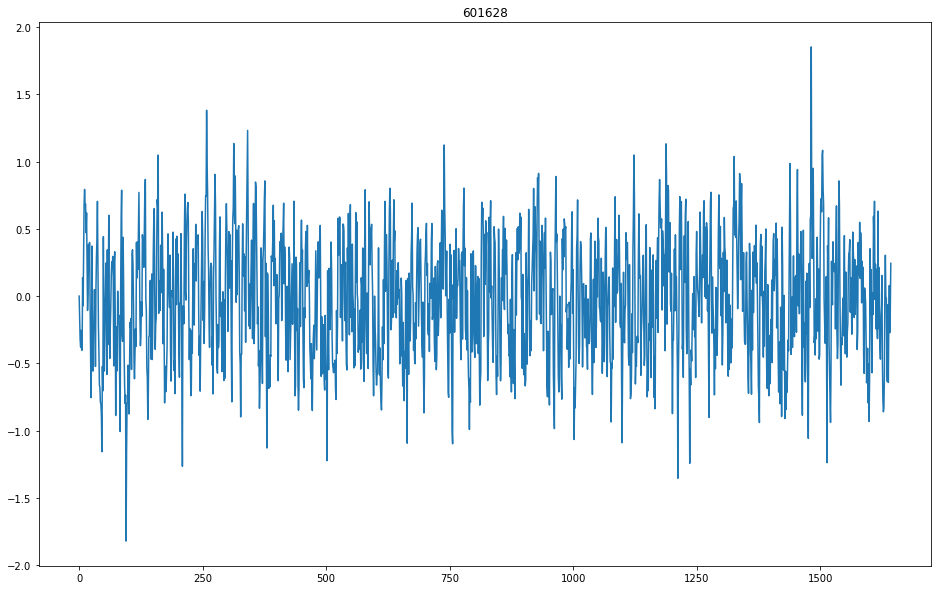

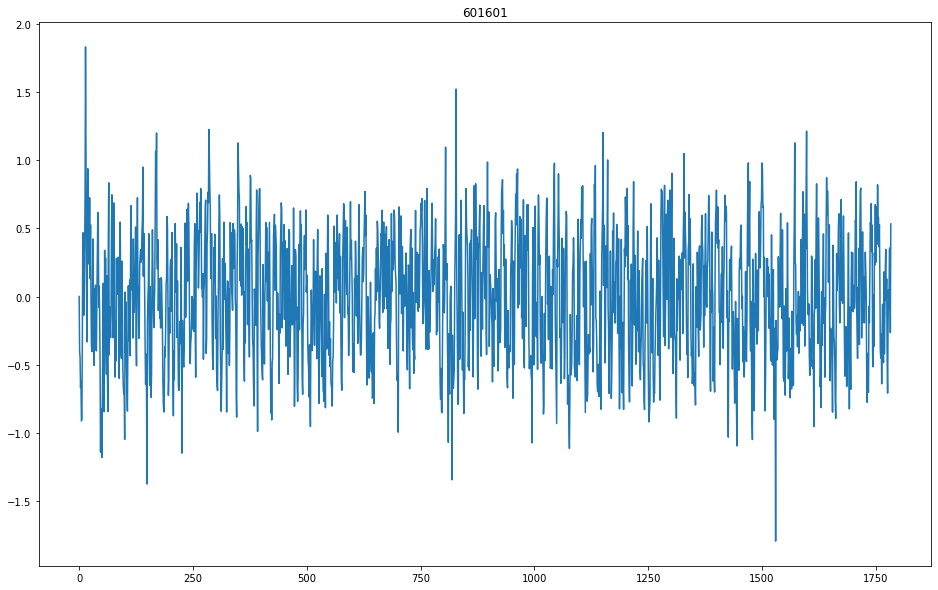

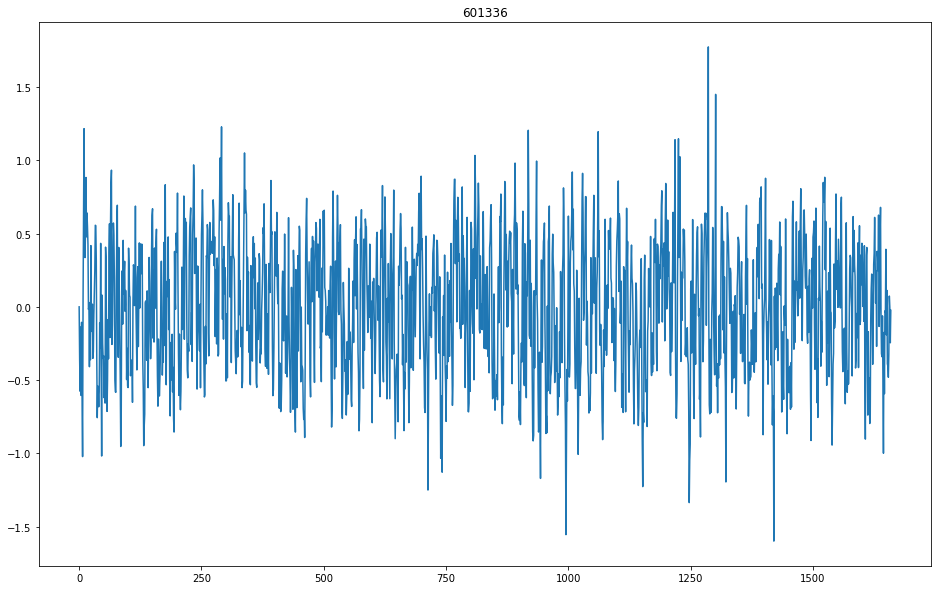

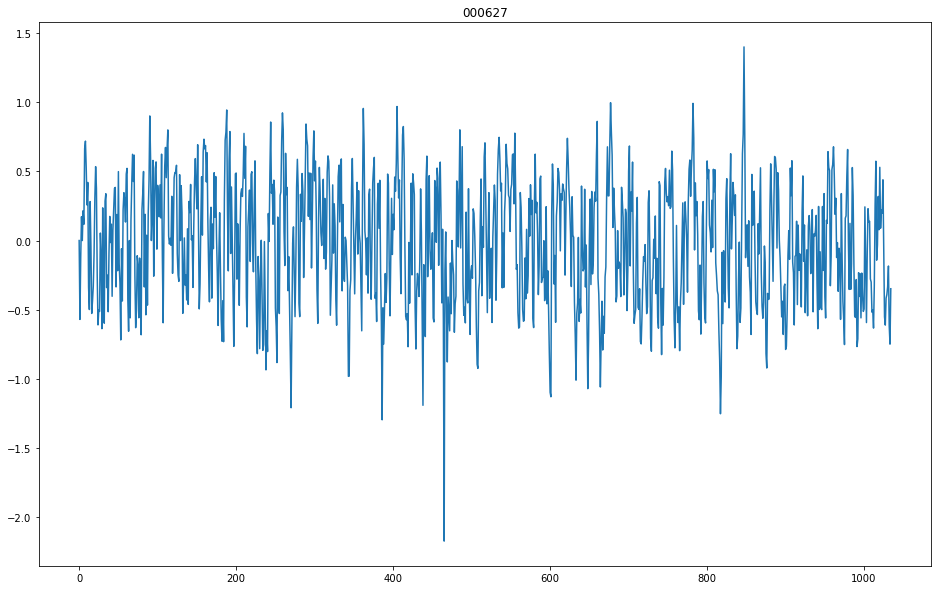

In [61]:
i = 0
period = 4096
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "price.osci."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- before the last signal, let's do some analysis of skewness and kurtosis

In [62]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1.5, 0.05)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [63]:
%%time
get_list_signal_stat("price.osci.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)

# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 36s



training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 36s


601318 train sharpe  0.5087595465967489 test sharpe  -0.42608260468198916
601628 train sharpe  0.2450578436138763 test sharpe  0.3299693488974813
601601 train sharpe  0.25572174031900163 test sharpe  -0.7541414262229281
000627 train sharpe  0.1408307287900117 test sharpe  -0.24352930715288915
train sharpe:  0.3866015567397225 test sharpe:  -0.3058116229038989
Wall time: 500 ms


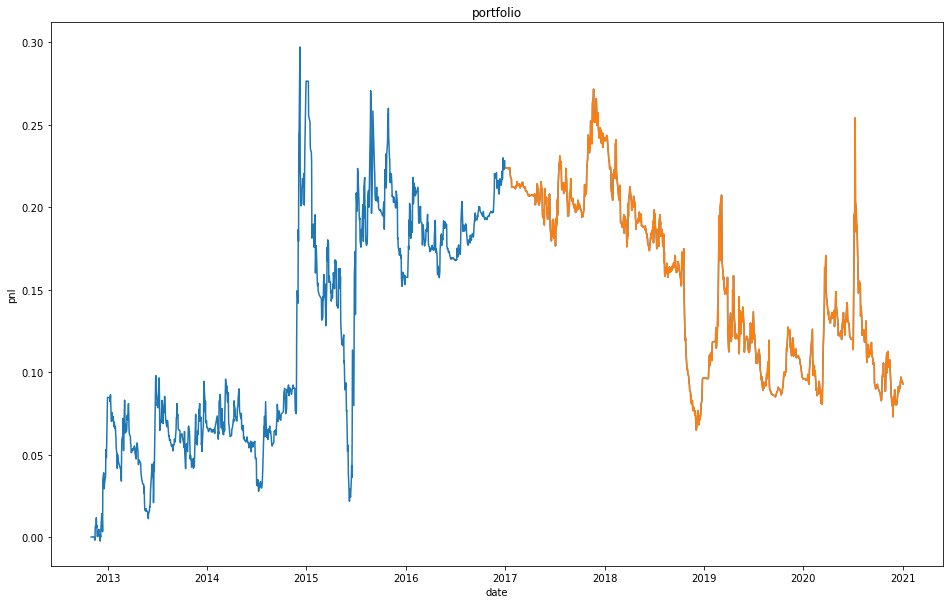

In [64]:
%%time
signal_stat = get_list_signal_result("price.osci.4096", product_list, reverse=1, min_pnl=0.001, min_num=20)

# 601318 train sharpe  0.5087595465967489 test sharpe  -0.42608260468198916
# 601628 train sharpe  0.2450578436138763 test sharpe  0.3299693488974813
# 601601 train sharpe  0.25572174031900163 test sharpe  -0.7541414262229281
# 000627 train sharpe  0.1408307287900117 test sharpe  -0.24352930715288915
# train sharpe:  0.3866015567397225 test sharpe:  -0.3058116229038989
# Wall time: 500 ms





In [65]:
from scipy.stats import kurtosis
from scipy.stats import skew
def get_signal_moment(signal, product_list, period):
    for product in product_list:
        all_dates = os.listdir(DATA_PATH + product)
        all_signal = get_all_signal(np.array(all_dates), product, signal+"."+str(period), period, SIGNAL_PATH=SAVE_PATH)
        print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [66]:
%%time
get_signal_moment("dbook", product_list, 4096)

# 601318 kurtosis= 6.592666041736772  skew= -0.09120109232075937
# 601628 kurtosis= 3.543108150564713  skew= -0.194981649206472
# 601601 kurtosis= 5.597717794603272  skew= -0.4994665198143758
# 601336 kurtosis= 3.94293533046311  skew= -0.1553229257334452
# 000627 kurtosis= 8.047026913952756  skew= -0.8241800371909361
# Wall time: 4.3 s





601318 kurtosis= 6.592666041736772  skew= -0.09120109232075937
601628 kurtosis= 3.543108150564713  skew= -0.194981649206472
601601 kurtosis= 5.597717794603272  skew= -0.4994665198143758
601336 kurtosis= 3.94293533046311  skew= -0.1553229257334452
000627 kurtosis= 8.047026913952756  skew= -0.8241800371909361
Wall time: 4.3 s


In [67]:
%%time
get_signal_moment("range.pos", product_list, 4096)

# 601318 kurtosis= 2.248361161352808  skew= 0.06812704724786343
# 601628 kurtosis= 2.578560195670181  skew= 0.15883536182268318
# 601601 kurtosis= 2.4365563194480515  skew= 0.11392122248564979
# 601336 kurtosis= 2.4195833330372336  skew= 0.03975338520642056
# 000627 kurtosis= 2.345908504444405  skew= 0.031739397354160204
# Wall time: 4.24 s



601318 kurtosis= 2.248361161352808  skew= 0.06812704724786343
601628 kurtosis= 2.578560195670181  skew= 0.15883536182268318
601601 kurtosis= 2.4365563194480515  skew= 0.11392122248564979
601336 kurtosis= 2.4195833330372336  skew= 0.03975338520642056
000627 kurtosis= 2.345908504444405  skew= 0.031739397354160204
Wall time: 4.24 s


In [68]:
%%time
get_signal_moment("ma.dif.10", product_list, 4096)

# 601318 kurtosis= 7.118438963629093  skew= -0.2935010295781392
# 601628 kurtosis= 7.934510980891239  skew= 0.4785614989041841
# 601601 kurtosis= 5.624899200332194  skew= -0.014611827301639319
# 601336 kurtosis= 6.762149278523134  skew= 0.10471172224776952
# 000627 kurtosis= 9.473948113289387  skew= -0.758029814339513
# Wall time: 4.32 s





601318 kurtosis= 7.118438963629093  skew= -0.2935010295781392
601628 kurtosis= 7.934510980891239  skew= 0.4785614989041841
601601 kurtosis= 5.624899200332194  skew= -0.014611827301639319
601336 kurtosis= 6.762149278523134  skew= 0.10471172224776952
000627 kurtosis= 9.473948113289387  skew= -0.758029814339513
Wall time: 4.32 s


In [69]:
%%time
get_signal_moment("price.osci", product_list, 4096)

# 601318 kurtosis= 2.500519556294866  skew= -0.08360753956036988
# 601628 kurtosis= 2.7224343133836406  skew= -0.00974303389631664
# 601601 kurtosis= 2.5816187744875543  skew= 0.0032130418044840335
# 601336 kurtosis= 2.5886386769683347  skew= -0.020233825510269383
# 000627 kurtosis= 2.7369638025787792  skew= -0.16801289567174746
# Wall time: 4.39 s




601318 kurtosis= 2.500519556294866  skew= -0.08360753956036988
601628 kurtosis= 2.7224343133836406  skew= -0.00974303389631664
601601 kurtosis= 2.5816187744875543  skew= 0.0032130418044840335
601336 kurtosis= 2.5886386769683347  skew= -0.020233825510269383
000627 kurtosis= 2.7369638025787792  skew= -0.16801289567174746
Wall time: 4.39 s


In [70]:
%%time
get_signal_moment("nr", product_list, 4096)

# 601318 kurtosis= 3.6581947983485867  skew= 0.14350602136693238
# 601628 kurtosis= 5.348082303223859  skew= 0.0441750974622301
# 601601 kurtosis= 4.455584719796218  skew= 0.1376638727649907
# 601336 kurtosis= 3.846738196686029  skew= 0.09606736116030347
# 000627 kurtosis= 11.925102716858003  skew= 1.0218353427016125
# Wall time: 7.71 s






601318 kurtosis= 3.6581947983485867  skew= 0.14350602136693238
601628 kurtosis= 5.348082303223859  skew= 0.0441750974622301
601601 kurtosis= 4.455584719796218  skew= 0.1376638727649907
601336 kurtosis= 3.846738196686029  skew= 0.09606736116030347
000627 kurtosis= 11.925102716858003  skew= 1.0218353427016125
Wall time: 7.71 s


In [71]:
class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values
    

In [72]:
x11 = foctor_kdj_k_period()
for product in product_list:
    create_signal_path(x11, product, SAVE_PATH)

e:/intern/tmp pkl/601318/kdj.k.4096
e:/intern/tmp pkl/601628/kdj.k.4096
e:/intern/tmp pkl/601601/kdj.k.4096
e:/intern/tmp pkl/601336/kdj.k.4096
e:/intern/tmp pkl/000627/kdj.k.4096


In [73]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x11, product=product, HEAD_PATH=SAVE_PATH, n=8)
;

#Wall time: 1min 49s

Wall time: 1min 49s


''

601318 kurtosis= 1.8460892770132982  skew= 0.07596835761375996
601628 kurtosis= 1.8998728055083098  skew= 0.10129404204025962
601601 kurtosis= 1.876534068973457  skew= 0.0580117849967812
601336 kurtosis= 1.8451717197722706  skew= 0.07545375782286708
000627 kurtosis= 1.8634759693996912  skew= 0.025894628672892602


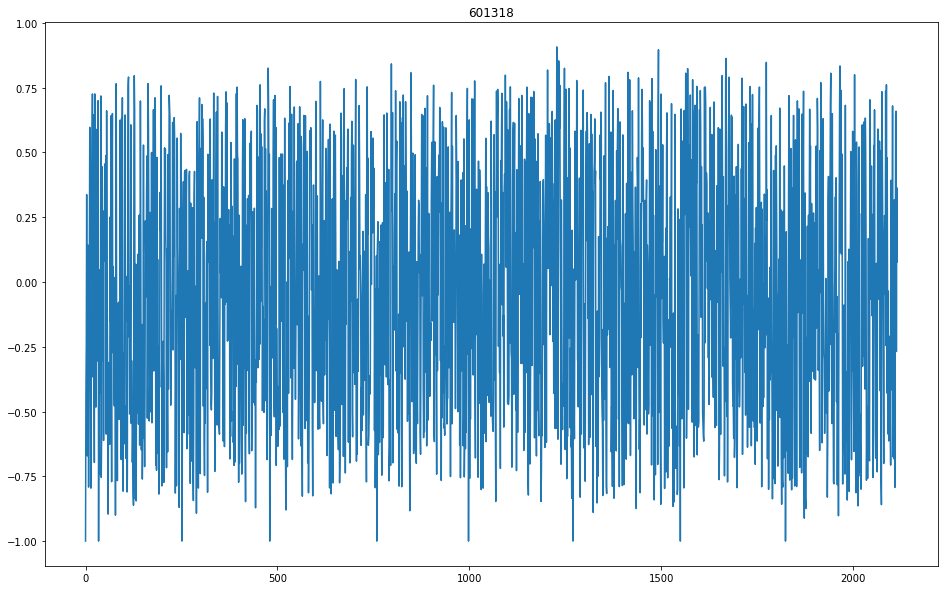

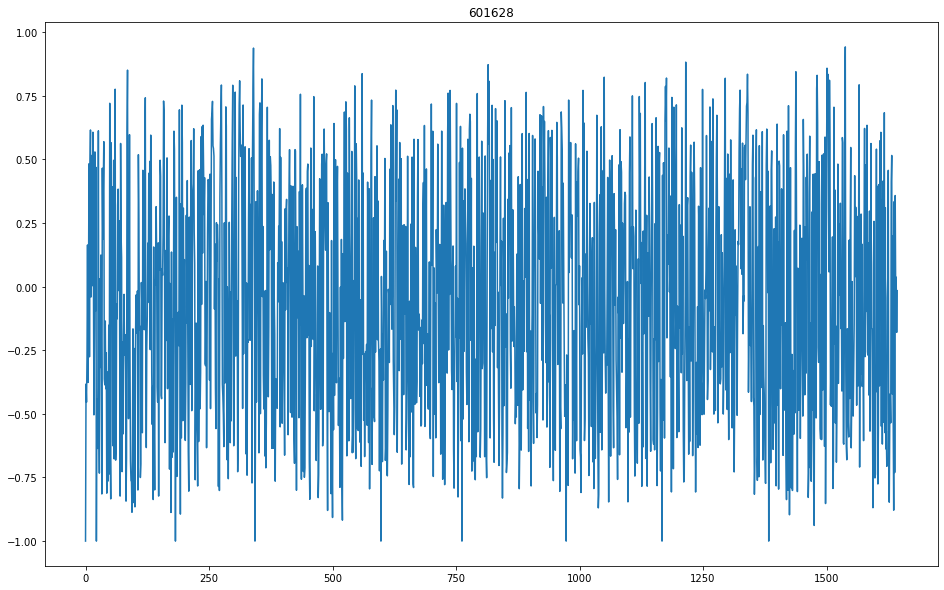

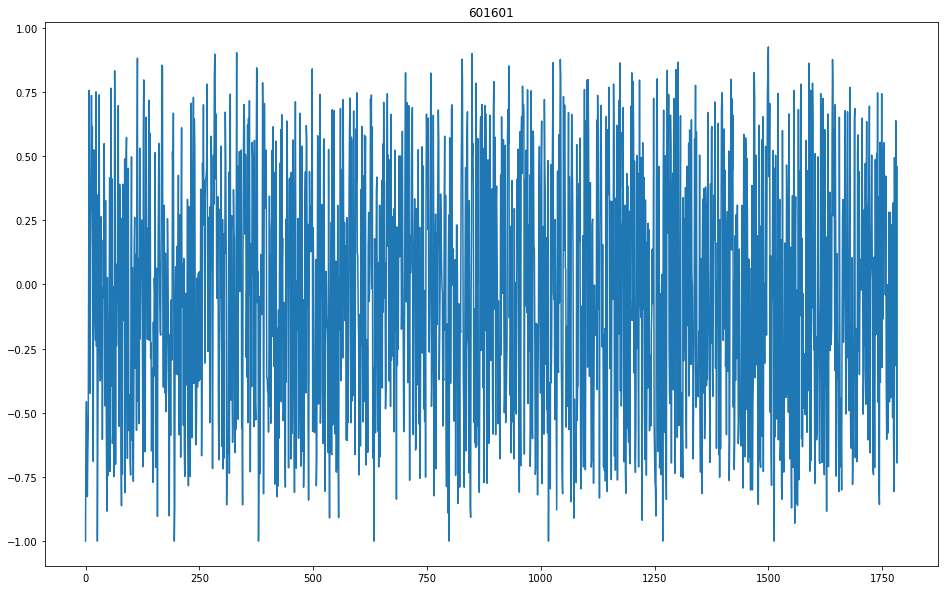

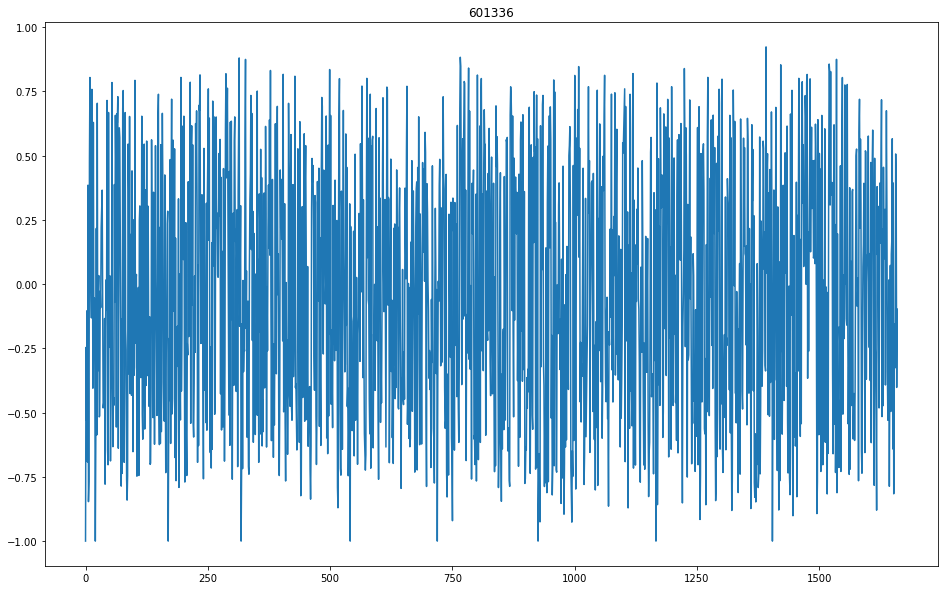

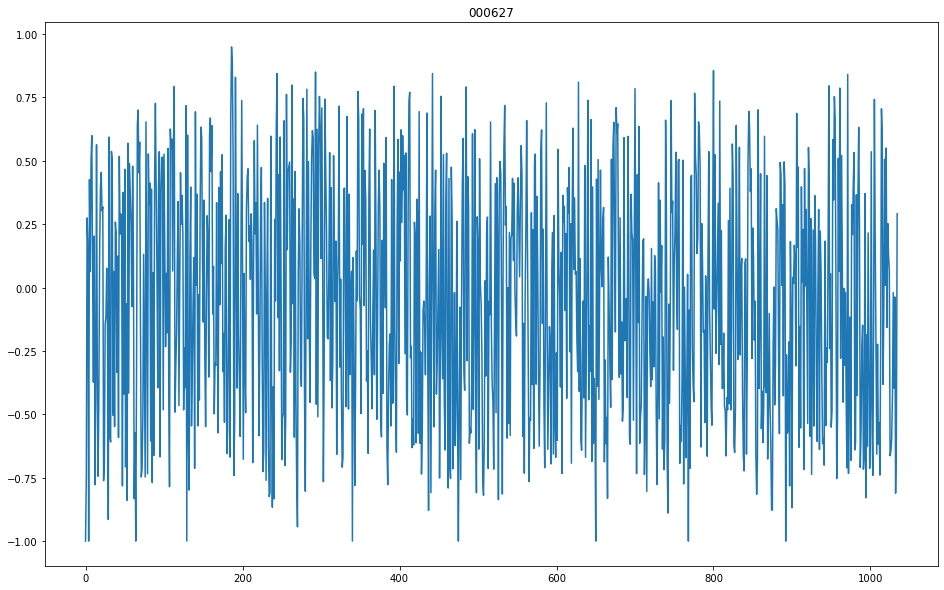

In [74]:
i = 0
period = 4096
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.k."+str(period), period,HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))


# 601318 kurtosis= 1.8460892770132982  skew= 0.07596835761375996
# 601628 kurtosis= 1.8998728055083098  skew= 0.10129404204025962
# 601601 kurtosis= 1.876534068973457  skew= 0.0580117849967812
# 601336 kurtosis= 1.8451717197722706  skew= 0.07545375782286708
# 000627 kurtosis= 1.8634759693996912  skew= 0.025894628672892602




- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

In [75]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [76]:
%%time
get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 1min 52s







training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 1min 52s


601318 train sharpe  0.3474791438544223 test sharpe  0.36873117814470147
601628 train sharpe  0.26289506006561436 test sharpe  0.014886037928828193
601601 train sharpe  0.3093994591490216 test sharpe  -1.0041159668453952
601336 train sharpe  0.10786317246940764 test sharpe  0.22797740137410757
000627 train sharpe  0.4269704939384594 test sharpe  0.5136871634149027
train sharpe:  0.45332446274247384 test sharpe:  0.14593580316754248
Wall time: 442 ms


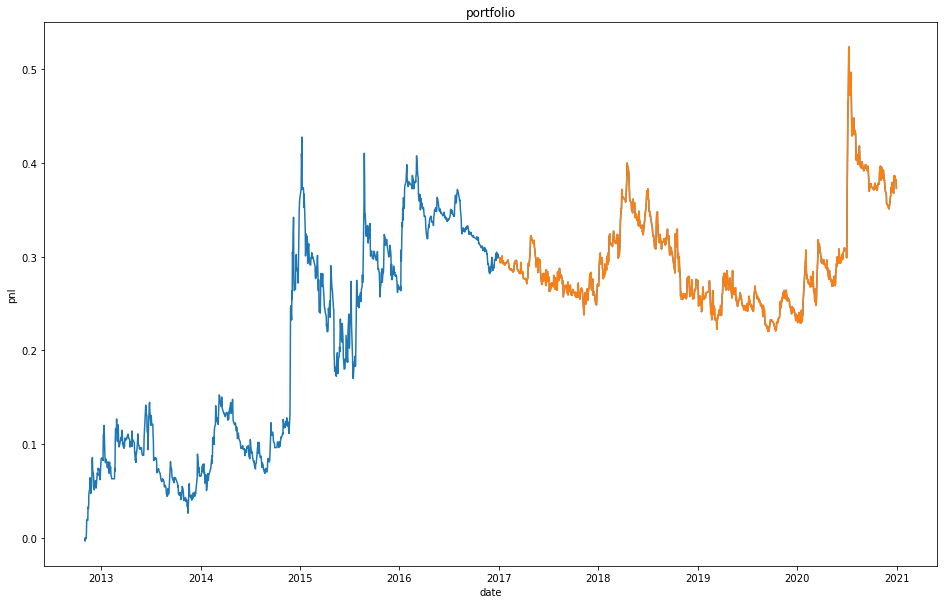

In [77]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, reverse=1, min_pnl=0.001, min_num=20)

# 601318 train sharpe  0.3474791438544223 test sharpe  0.36873117814470147
# 601628 train sharpe  0.26289506006561436 test sharpe  0.014886037928828193
# 601601 train sharpe  0.3093994591490216 test sharpe  -1.0041159668453952
# 601336 train sharpe  0.10786317246940764 test sharpe  0.22797740137410757
# 000627 train sharpe  0.4269704939384594 test sharpe  0.5136871634149027
# train sharpe:  0.45332446274247384 test sharpe:  0.14593580316754248
# Wall time: 442 ms






In [78]:
%%time
get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=-1)


# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 1min 4s



training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 1min 4s


In [79]:
class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                        adjust=True), round(period/5), adjust=True).values
    


In [80]:
x12 = foctor_kdj_j_period()
for product in product_list:
    create_signal_path(x12, product, SAVE_PATH)

e:/intern/tmp pkl/601318/kdj.j.4096
e:/intern/tmp pkl/601628/kdj.j.4096
e:/intern/tmp pkl/601601/kdj.j.4096
e:/intern/tmp pkl/601336/kdj.j.4096
e:/intern/tmp pkl/000627/kdj.j.4096


In [81]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x12, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
# Wall time: 1min 59s

Wall time: 1min 59s


''

601318 kurtosis= 1.9841953071475136  skew= 0.07128907747274059
601628 kurtosis= 2.1159238777025706  skew= 0.09060541070926059
601601 kurtosis= 2.0555703900151587  skew= 0.08387766415649778
601336 kurtosis= 2.0646526774991942  skew= 0.0789398068737187
000627 kurtosis= 2.0308019548311287  skew= 0.0107369440124854
Wall time: 4.4 s


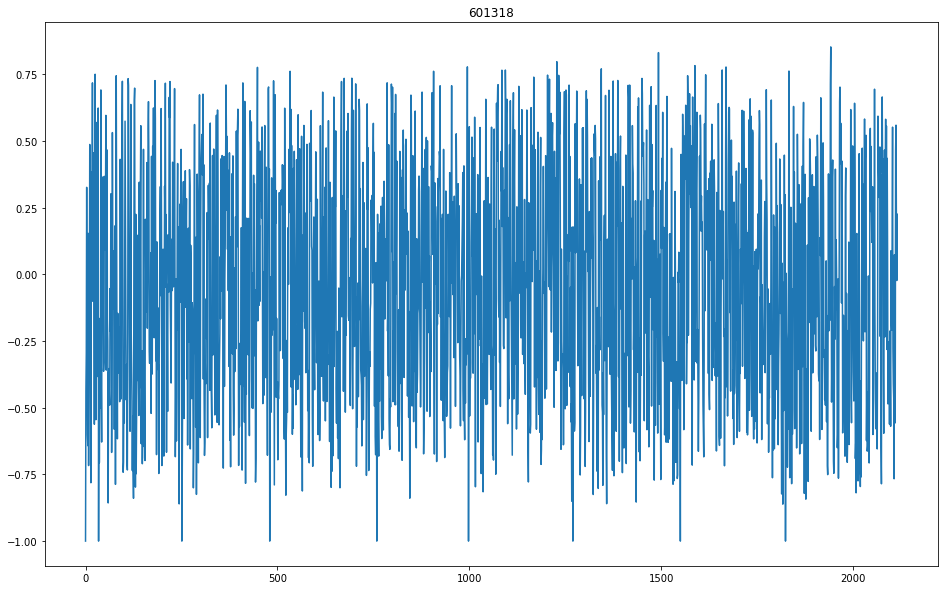

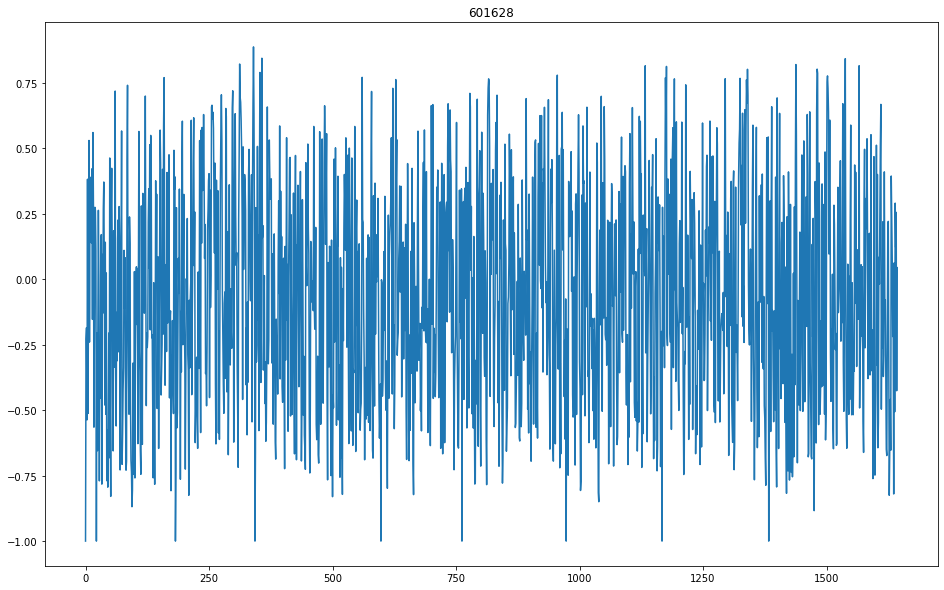

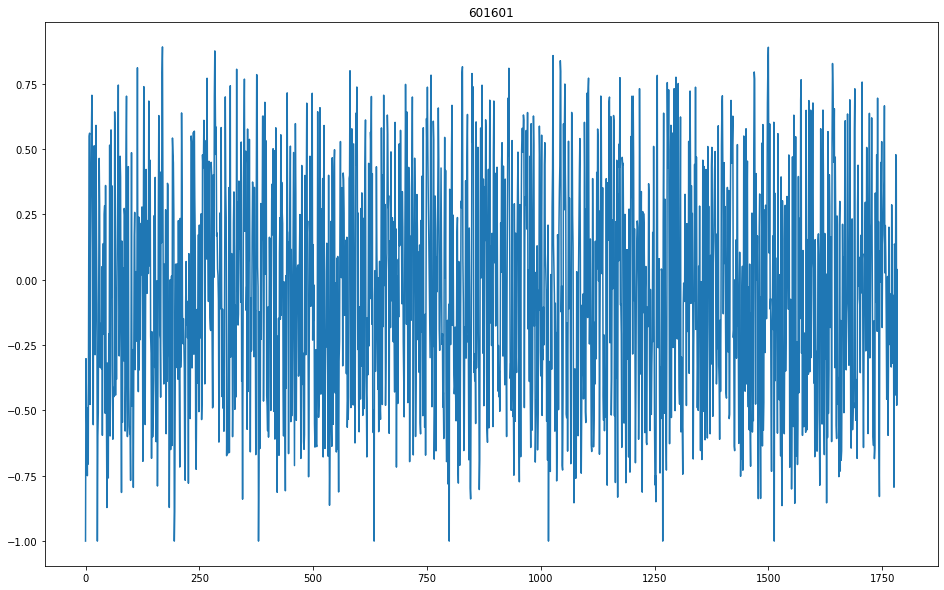

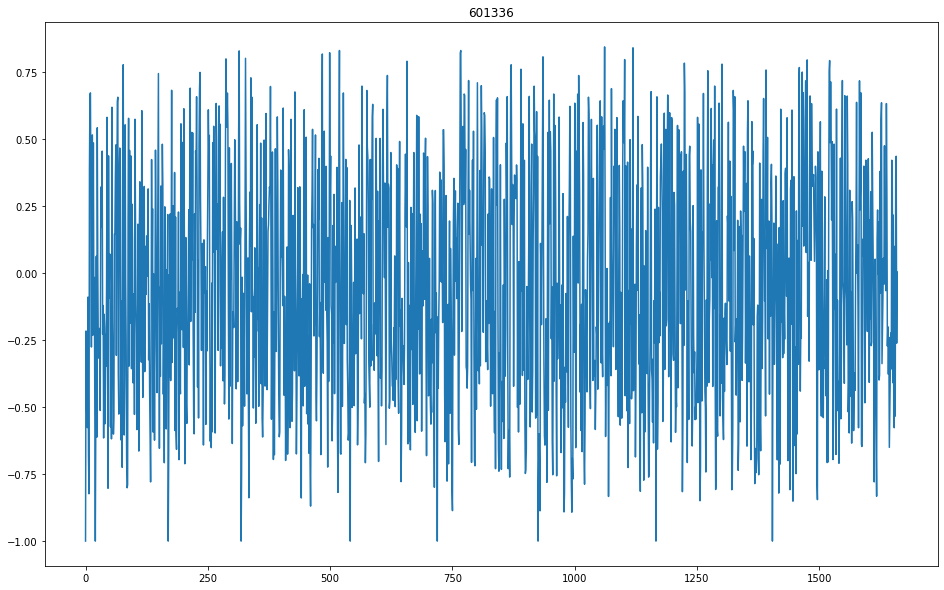

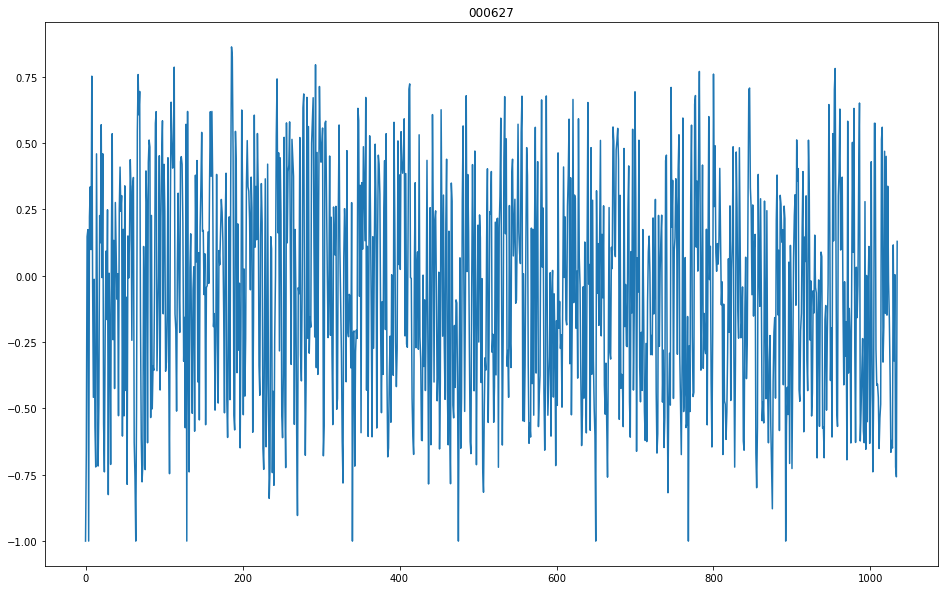

In [82]:
%%time
i = 0
period = 4096
for product in product_list:
    all_dates = os.listdir(DATA_PATH + product)
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.j."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1;
    plt.figure(i, figsize=(16, 10));
    plt.title(product);
    plt.plot(all_signal);
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal));
    
# 601318 kurtosis= 1.9841953071475136  skew= 0.07128907747274059
# 601628 kurtosis= 2.1159238777025706  skew= 0.09060541070926059
# 601601 kurtosis= 2.0555703900151587  skew= 0.08387766415649778
# 601336 kurtosis= 2.0646526774991942  skew= 0.0789398068737187
# 000627 kurtosis= 2.0308019548311287  skew= 0.0107369440124854
# Wall time: 4.4 s







In [83]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
bitmex_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat



In [84]:
%%time
get_list_signal_stat("kdj.j.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


# training
# 601318
# 5 4
# 601628
# 5 4
# 601601
# 5 4
# 601336
# 5 4
# 000627
# 5 4
# testing
# 601318
# 601628
# 601601
# 601336
# 000627
# Wall time: 1h 1min 24s







training
601318
5 4
601628
5 4
601601
5 4
601336
5 4
000627
5 4
testing
601318
601628
601601
601336
000627
Wall time: 1h 1min 24s


601318 train sharpe  0.3399832447437964 test sharpe  0.1695488680396846
601628 train sharpe  0.2948440893140072 test sharpe  -0.03104220965287187
601601 train sharpe  0.33661727549034764 test sharpe  -0.899405226183208
601336 train sharpe  0.2933033281491069 test sharpe  0.6580657051475857
000627 train sharpe  0.10407286876705349 test sharpe  0.14264359797340384
train sharpe:  0.40075539206419086 test sharpe:  0.09560545268268583


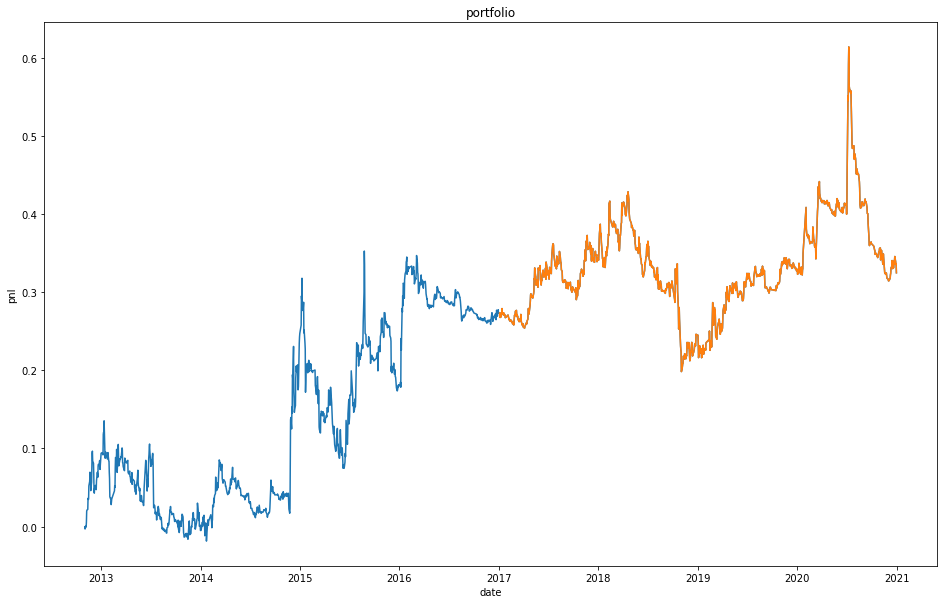

In [85]:
signal_stat = get_list_signal_result("kdj.j.4096", product_list,min_pnl=0.001, min_num=20)

# 601318 train sharpe  0.3399832447437964 test sharpe  0.1695488680396846
# 601628 train sharpe  0.2948440893140072 test sharpe  -0.03104220965287187
# 601601 train sharpe  0.33661727549034764 test sharpe  -0.899405226183208
# 601336 train sharpe  0.2933033281491069 test sharpe  0.6580657051475857
# 000627 train sharpe  0.10407286876705349 test sharpe  0.14264359797340384
# train sharpe:  0.40075539206419086 test sharpe:  0.09560545268268583


